In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
import implicit

from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, plot_confusion_matrix, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
from scipy.sparse import csc_matrix, csr_matrix
from sparsesvd import sparsesvd
from sklearn.preprocessing import LabelEncoder

## Utils

In [75]:
def hit_rate_one(ground_truth, recommendation, k):
    if len(list(set(ground_truth) & set(recommendation[:k]))) != 0:
        return 1
    return 0

def hit_rate(ground_truth, recommendation, k):
    return sum([hit_rate_one(ground_truth[i], recommendation[i], k) for i in range(len(recommendation))]) / len(recommendation)

def get_binary_relevance(ground_truth, recomendation):
    relevance = []
    for i in range(len(recomendation)):
        if recomendation[i] in ground_truth:
            relevance.append(1)
        else:
            relevance.append(0)
    return relevance

def precision(recommendation, k):
    return sum(recommendation[:k]) / k

def AP(ground_truth, recommendation, k):
    if k > len(recommendation):
        k = len(recommendation)
    relevance = get_binary_relevance(ground_truth, recommendation)
    if sum(relevance[:k]) == 0:
        return 0
    return sum([relevance[i] * precision(relevance, i + 1) for i in range(k)]) / sum(relevance[:k])

def MAP(ground_truth, recommendation, k):
    return sum([AP(ground_truth[i], recommendation[i], k) for i in range(len(recommendation))]) / len(recommendation)

def DCG_one(ground_truth, recommendation, k):
    if k > len(recommendation):
        k = len(recommendation)
    relevance = get_binary_relevance(ground_truth, recommendation)
    return sum([(2 ** relevance[i] - 1) / (math.log2(i + 2)) for i in range(k)])

def best_DCG_one(ground_truth, recommendation, k):
    if k > len(ground_truth):
        relevance = [1] * len(ground_truth) + [0] * (k - len(ground_truth))
    else:
        relevance = [1] * k
    return sum([(2 ** relevance[i] - 1) / (math.log2(i + 2)) for i in range(k)])

def NDCG_one(ground_truth, recommendation, k):
    return DCG_one(ground_truth, recommendation, k) / best_DCG_one(ground_truth, recommendation, k)

def NDCG(ground_truth, recommendation, k):
    return sum([NDCG_one(ground_truth[i], recommendation[i], k) for i in range(len(recommendation))]) / len(recommendation)

def print_metrics(ground_truth, recommendation, k):
    df = pd.DataFrame({'metric': ['HitRate@k', 'MAP@k', 'NDCG@k'], 
                       'value': [hit_rate(ground_truth, recommendation, k),
                                 MAP(ground_truth, recommendation, k),
                                 NDCG(ground_truth, recommendation, k)]})
    print(df)

## Train-val-test split

In [ ]:
orders = pd.read_csv('data/orders.csv')
order_products__prior = pd.read_csv('data/order_products__prior.csv') 
order_products__train = pd.read_csv('data/order_products__train.csv')

In [ ]:
orders_available = orders[orders['eval_set'] != 'test']
orders_available.head(12)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [ ]:
order_id_test_labels = orders_available.groupby(by=['user_id']).last()['order_id'].values
order_id_test_labels, len(order_id_test_labels)

(array([1187899, 1492625, 1402502, ..., 1005822, 1882108,  272231],
       dtype=int64),
 206209)

In [ ]:
orders_available['eval_set'] = 'TRAIN'
orders_available.loc[orders_available['order_id'].isin(order_id_test_labels), 'eval_set'] = 'TEST_LABELS'

<ipython-input-6-066c11853295>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_available['eval_set'] = 'TRAIN'
C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
orders_available.head(12)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,TRAIN,1,2,8,NaN
1,2398795,1,TRAIN,2,3,7,15.0
2,473747,1,TRAIN,3,3,12,21.0
3,2254736,1,TRAIN,4,4,7,29.0
4,431534,1,TRAIN,5,4,15,28.0
5,3367565,1,TRAIN,6,2,7,19.0
6,550135,1,TRAIN,7,1,9,20.0
7,3108588,1,TRAIN,8,1,14,14.0
8,2295261,1,TRAIN,9,1,16,0.0
9,2550362,1,TRAIN,10,4,8,30.0


In [ ]:
order_id_val_labels = orders_available[orders_available['eval_set'] != 'TEST_LABELS'].groupby(by=['user_id']).last()['order_id'].values
order_id_val_labels, len(order_id_val_labels)

(array([2550362,  839880,  521107, ..., 2991173, 1285346, 2977660],
       dtype=int64),
 206209)

In [ ]:
orders_available.loc[orders_available['order_id'].isin(order_id_val_labels), 'eval_set'] = 'VAL_LABELS'

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
orders_available.head(12)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,TRAIN,1,2,8,NaN
1,2398795,1,TRAIN,2,3,7,15.0
2,473747,1,TRAIN,3,3,12,21.0
3,2254736,1,TRAIN,4,4,7,29.0
4,431534,1,TRAIN,5,4,15,28.0
5,3367565,1,TRAIN,6,2,7,19.0
6,550135,1,TRAIN,7,1,9,20.0
7,3108588,1,TRAIN,8,1,14,14.0
8,2295261,1,TRAIN,9,1,16,0.0
9,2550362,1,VAL_LABELS,10,4,8,30.0


In [ ]:
order_id_train_labels = orders_available[(orders_available['eval_set'] != 'TEST_LABELS') & (orders_available['eval_set'] != 'VAL_LABELS')].groupby(by=['user_id']).last()['order_id'].values
order_id_train_labels, len(order_id_train_labels)

(array([2295261, 3268552,  676467, ..., 2832273, 2239861,  626363],
       dtype=int64),
 206209)

In [ ]:
orders_available.loc[orders_available['order_id'].isin(order_id_train_labels), 'eval_set'] = 'TRAIN_LABELS'

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
orders_available.head(12)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,TRAIN,1,2,8,NaN
1,2398795,1,TRAIN,2,3,7,15.0
2,473747,1,TRAIN,3,3,12,21.0
3,2254736,1,TRAIN,4,4,7,29.0
4,431534,1,TRAIN,5,4,15,28.0
5,3367565,1,TRAIN,6,2,7,19.0
6,550135,1,TRAIN,7,1,9,20.0
7,3108588,1,TRAIN,8,1,14,14.0
8,2295261,1,TRAIN_LABELS,9,1,16,0.0
9,2550362,1,VAL_LABELS,10,4,8,30.0


In [ ]:
order_products = pd.concat([order_products__prior, order_products__train])

In [ ]:
df_full = order_products.merge(orders_available, on='order_id')
df_full.head(3)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,TRAIN,3,5,9,8.0
1,2,28985,2,1,202279,TRAIN,3,5,9,8.0
2,2,9327,3,0,202279,TRAIN,3,5,9,8.0


In [ ]:
df_full = df_full.sort_values(by=['user_id', 'order_number', 'add_to_cart_order'])
df_full.head(3)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
24076664,2539329,196,1,0,1,TRAIN,1,2,8,NaN
24076665,2539329,14084,2,0,1,TRAIN,1,2,8,NaN
24076666,2539329,12427,3,0,1,TRAIN,1,2,8,NaN


In [ ]:
df_full = df_full[['user_id', 'product_id', 'eval_set']]
df_full.head(3)

,user_id,product_id,eval_set
24076664,1,196,TRAIN
24076665,1,14084,TRAIN
24076666,1,12427,TRAIN


In [ ]:
df_full.to_pickle('data/meta/df_full.pkl')

**Train**

In [ ]:
df_train = df_full[df_full['eval_set'] == 'TRAIN']
df_train.head(3)

,user_id,product_id,eval_set
24076664,1,196,TRAIN
24076665,1,14084,TRAIN
24076666,1,12427,TRAIN


In [ ]:
df_train_gb = df_train.groupby(['user_id', 'product_id'], as_index=False).count()[['user_id', 'product_id', 'eval_set']]
df_train_gb = df_train_gb.rename(columns={'eval_set': 'rating'})
df_train_gb.head(3)

,user_id,product_id,rating
0,1,196,8
1,1,10258,7
2,1,10326,1


In [ ]:
df_train_tmp = df_train_gb.pivot_table(index='user_id', values=['rating'], aggfunc={'rating': lambda x: sum(x)}).reset_index()
df_train_tmp = df_train_tmp.rename(columns={'rating': 'rating_sum'})
df_train_tmp.head(3)

,user_id,rating_sum
0,1,44
1,2,170
2,3,71


In [ ]:
df_train_gb = df_train_gb.merge(df_train_tmp, on='user_id')
df_train_gb['rating_norm'] = df_train_gb['rating'] / df_train_gb['rating_sum']
df_train_gb.head(3)

,user_id,product_id,rating,rating_sum,rating_norm
0,1,196,8,44,0.181818
1,1,10258,7,44,0.159091
2,1,10326,1,44,0.022727


In [ ]:
df_train_labels = df_full[df_full['eval_set'] == 'TRAIN_LABELS'][['user_id', 'product_id']]
df_train_labels['reordered'] = 1
df_train_gb = df_train_gb.merge(df_train_labels, how='left', on=['user_id', 'product_id'])
df_train_gb['reordered'] = df_train_gb['reordered'].fillna(0)
df_train_gb['reordered'] = df_train_gb['reordered'].astype('int')
df_train_gb.head()

,user_id,product_id,rating,rating_sum,rating_norm,reordered
0,1,196,8,44,0.181818,1
1,1,10258,7,44,0.159091,1
2,1,10326,1,44,0.022727,0
3,1,12427,8,44,0.181818,1
4,1,13032,2,44,0.045455,0


In [ ]:
df_train_gb.to_pickle('data/meta/df_train.pkl')

**Val**

In [ ]:
df_val = df_full[df_full['eval_set'].isin(['TRAIN', 'TRAIN_LABELS'])]
df_val.head(3)

,user_id,product_id,eval_set
24076664,1,196,TRAIN
24076665,1,14084,TRAIN
24076666,1,12427,TRAIN


In [ ]:
df_val_gb = df_val.groupby(['user_id', 'product_id'], as_index=False).count()[['user_id', 'product_id', 'eval_set']]
df_val_gb = df_val_gb.rename(columns={'eval_set': 'rating'})
df_val_gb.head(3)

,user_id,product_id,rating
0,1,196,9
1,1,10258,8
2,1,10326,1


In [ ]:
df_val_tmp = df_val_gb.pivot_table(index='user_id', values=['rating'], aggfunc={'rating': lambda x: sum(x)}).reset_index()
df_val_tmp = df_val_tmp.rename(columns={'rating': 'rating_sum'})
df_val_tmp.head(3)

,user_id,rating_sum
0,1,50
1,2,179
2,3,77


In [ ]:
df_val_gb = df_val_gb.merge(df_val_tmp, on='user_id')
df_val_gb['rating_norm'] = df_val_gb['rating'] / df_val_gb['rating_sum']
df_val_gb.head(3)

,user_id,product_id,rating,rating_sum,rating_norm
0,1,196,9,50,0.18
1,1,10258,8,50,0.16
2,1,10326,1,50,0.02


In [ ]:
df_val_labels = df_full[df_full['eval_set'] == 'VAL_LABELS'][['user_id', 'product_id']]
df_val_labels['reordered'] = 1
df_val_gb = df_val_gb.merge(df_val_labels, how='left', on=['user_id', 'product_id'])
df_val_gb['reordered'] = df_val_gb['reordered'].fillna(0)
df_val_gb['reordered'] = df_val_gb['reordered'].astype('int')
df_val_gb.head()

,user_id,product_id,rating,rating_sum,rating_norm,reordered
0,1,196,9,50,0.18,1
1,1,10258,8,50,0.16,1
2,1,10326,1,50,0.02,0
3,1,12427,9,50,0.18,1
4,1,13032,2,50,0.04,1


In [ ]:
df_val_gb.to_pickle('data/meta/df_val.pkl')

**Test**

In [ ]:
df_test = df_full[df_full['eval_set'].isin(['TRAIN', 'TRAIN_LABELS', 'VAL_LABELS'])]
df_test.head(3)

,user_id,product_id,eval_set
24076664,1,196,TRAIN
24076665,1,14084,TRAIN
24076666,1,12427,TRAIN


In [ ]:
df_test_gb = df_test.groupby(['user_id', 'product_id'], as_index=False).count()[['user_id', 'product_id', 'eval_set']]
df_test_gb = df_test_gb.rename(columns={'eval_set': 'rating'})
df_test_gb.head(3)

,user_id,product_id,rating
0,1,196,10
1,1,10258,9
2,1,10326,1


In [ ]:
df_test_tmp = df_test_gb.pivot_table(index='user_id', values=['rating'], aggfunc={'rating': lambda x: sum(x)}).reset_index()
df_test_tmp = df_test_tmp.rename(columns={'rating': 'rating_sum'})
df_test_tmp.head(3)

,user_id,rating_sum
0,1,59
1,2,195
2,3,82


In [ ]:
df_test_gb = df_test_gb.merge(df_test_tmp, on='user_id')
df_test_gb['rating_norm'] = df_test_gb['rating'] / df_test_gb['rating_sum']
df_test_gb.head(3)

,user_id,product_id,rating,rating_sum,rating_norm
0,1,196,10,59,0.169492
1,1,10258,9,59,0.152542
2,1,10326,1,59,0.016949


In [ ]:
df_test_labels = df_full[df_full['eval_set'] == 'TEST_LABELS'][['user_id', 'product_id']]
df_test_labels['reordered'] = 1
df_test_gb = df_test_gb.merge(df_test_labels, how='left', on=['user_id', 'product_id'])
df_test_gb['reordered'] = df_test_gb['reordered'].fillna(0)
df_test_gb['reordered'] = df_test_gb['reordered'].astype('int')
df_test_gb.head()

,user_id,product_id,rating,rating_sum,rating_norm,reordered
0,1,196,10,59,0.169492,1
1,1,10258,9,59,0.152542,1
2,1,10326,1,59,0.016949,0
3,1,12427,10,59,0.169492,0
4,1,13032,3,59,0.050847,1


In [ ]:
df_test_gb.to_pickle('data/meta/df_test.pkl')

**Pivot table (for calculating metrics)**

In [ ]:
val_pivot = df_val_labels.pivot_table(index='user_id', values=['product_id'], aggfunc={'product_id': lambda x: list(x)}).reset_index()
val_pivot = val_pivot.rename({'product_id': 'val_products'}, axis=1)
val_pivot.head()

,user_id,val_products
0,1,"[196, 46149, 39657, 38928, 25133, 10258, 35951..."
1,2,"[24852, 16589, 1559, 19156, 18523, 22825, 2741..."
2,3,"[39190, 47766, 21903, 43961, 17668]"
3,4,"[22199, 25146]"
4,5,"[27344, 24535, 43693, 40706, 16168, 21413, 139..."


In [ ]:
test_pivot = df_test_labels.pivot_table(index='user_id', values=['product_id'], aggfunc={'product_id': lambda x: list(x)}).reset_index()
test_pivot = test_pivot.rename({'product_id': 'test_products'}, axis=1)
test_pivot.head()

,user_id,test_products
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,3,"[39190, 18599, 23650, 21903, 47766, 24810]"
3,4,"[26576, 25623, 21573]"
4,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482..."


In [ ]:
pivot_table = val_pivot.merge(test_pivot, on='user_id')
pivot_table.head()

,user_id,val_products,test_products
0,1,"[196, 46149, 39657, 38928, 25133, 10258, 35951...","[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,"[24852, 16589, 1559, 19156, 18523, 22825, 2741...","[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,3,"[39190, 47766, 21903, 43961, 17668]","[39190, 18599, 23650, 21903, 47766, 24810]"
3,4,"[22199, 25146]","[26576, 25623, 21573]"
4,5,"[27344, 24535, 43693, 40706, 16168, 21413, 139...","[15349, 19057, 16185, 21413, 20843, 20114, 482..."


In [ ]:
pivot_table.to_pickle('data/meta/pivot_table.pkl')

## Most popular recommender

In [33]:
USER_COL = 'user_id'
ITEM_COL = 'product_id'
DEFAULT_RATING_COL = 'rating'
DEFAULT_K = 10

class MostPopularRecommender:
    
    def __init__(self):
        pass

    def fit(self, train_df, 
            col_user=USER_COL, 
            col_item=ITEM_COL,
            col_rating=DEFAULT_RATING_COL) -> None:
        """
        perform train procedure for the recommendation algorithm
        :param col_item: name for items column
        :param col_user: name for user column
        :param col_rating: name for rating column
        :param train_df: pandas data frame with users, items and ratings columns
        :return: None
        """
        self.train_df = train_df.copy()
        self.col_user = col_user
        self.col_item = col_item
        self.col_rating = col_rating
        
        self.items = np.unique(self.train_df[self.col_item].values)
        item_to_encodeditem = {x: i for i, x in enumerate(self.items)}
        self.train_df[self.col_item] = self.train_df[self.col_item].map(item_to_encodeditem)

    def predict(self, test_df, col_user=USER_COL, k=DEFAULT_K) -> pd.DataFrame:
        """
        predicts recommendations for test users
        :param test_df: pandas data frame with users column
        :param k: number of items to predict per user
        :return: prediction pandas data frame with two columns first contains user's
        and second contains list of recommended items
        """
        test_df_new = test_df.copy()
        popular_products = self.train_df.groupby(self.col_item)[self.col_rating].sum()
        popular_products_top = popular_products.sort_values(ascending=False)[:k].index
        encodeditem_to_item = {i: x for i, x in enumerate(self.items)}
        popular_products_top_encoded = [encodeditem_to_item.get(popular_products_top[j]) for j in range(k)]
        test_df_new['most_popular'] = [list(popular_products_top_encoded)] * len(test_df_new)
        return test_df_new

In [ ]:
pivot_table = pd.read_pickle('data/meta/pivot_table.pkl')

In [ ]:
df_val = pd.read_pickle('data/meta/df_val.pkl')

In [ ]:
mpr = MostPopularRecommender()
mpr.fit(df_val)

In [ ]:
pivot_table = mpr.predict(pivot_table)
pivot_table.head()

,user_id,val_products,test_products,most_popular
0,1,"[196, 46149, 39657, 38928, 25133, 10258, 35951...","[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
1,2,"[24852, 16589, 1559, 19156, 18523, 22825, 2741...","[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
2,3,"[39190, 47766, 21903, 43961, 17668]","[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
3,4,"[22199, 25146]","[26576, 25623, 21573]","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
4,5,"[27344, 24535, 43693, 40706, 16168, 21413, 139...","[15349, 19057, 16185, 21413, 20843, 20114, 482...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."


In [ ]:
pivot_table['most_popular_val_ap'] = [AP(pivot_table['val_products'][i], pivot_table['most_popular'][i], 10) 
                                       for i in range(len(pivot_table))]
pivot_table.head(3)

,user_id,val_products,test_products,most_popular,most_popular_val_ap
0,1,"[196, 46149, 39657, 38928, 25133, 10258, 35951...","[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.000000
1,2,"[24852, 16589, 1559, 19156, 18523, 22825, 2741...","[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.700000
2,3,"[39190, 47766, 21903, 43961, 17668]","[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.291667


In [ ]:
print_metrics(pivot_table['val_products'].values, pivot_table['most_popular'].values, 10)

      metric     value
0  HitRate@k  0.451285
1      MAP@k  0.217901
2     NDCG@k  0.096417


In [ ]:
pivot_table.to_pickle('data/meta/pivot_table_mp.pkl')

## ALS

In [ ]:
pivot_table = pd.read_pickle('data/meta/pivot_table_mp.pkl')

In [ ]:
df_val = pd.read_pickle('data/meta/df_val.pkl')

In [ ]:
df_val_new = df_val.copy()
df_val_new.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,reordered
0,1,196,9,50,0.18,1
1,1,10258,8,50,0.16,1
2,1,10326,1,50,0.02,0


In [ ]:
items = np.unique(df_val_new['product_id'].values)
item_to_encodeditem = {x: i for i, x in enumerate(items)}
df_val_new['product_id_new'] = df_val_new['product_id'].map(item_to_encodeditem)
encodeditem_to_item = {i: x for i, x in enumerate(items)}   

users = np.unique(df_val_new['user_id'].values)
user_to_encodeduser = {x: i for i, x in enumerate(users)}
df_val_new['user_id_new'] = df_val_new['user_id'].map(user_to_encodeduser)
encodeduser_to_user = {i: x for i, x in enumerate(users)}

In [ ]:
sparse_item_user = csr_matrix((df_val_new['rating'].astype(float), 
                               (df_val_new['product_id_new'], df_val_new['user_id_new'])))
sparse_user_item = csr_matrix((df_val_new['rating'].astype(float), 
                               (df_val_new['user_id_new'], df_val_new['product_id_new'])))

In [ ]:
model_als = implicit.als.AlternatingLeastSquares(regularization=0.3, iterations=20)
model_als.fit(sparse_item_user)

In [ ]:
recommendations_ids_enc = model_als.recommend_all(sparse_user_item, filter_already_liked_items=False)

In [ ]:
recommendations_ids = [[encodeditem_to_item.get(j) for j in i] for i in recommendations_ids_enc]

In [ ]:
pivot_table['als'] = recommendations_ids

In [ ]:
pivot_table['als_val_ap'] = [AP(pivot_table['val_products'][i], pivot_table['als'][i], 10) 
                                       for i in range(len(pivot_table))]
pivot_table.head(3)

,user_id,val_products,test_products,most_popular,most_popular_val_ap,als,als_val_ap
0,1,"[196, 46149, 39657, 38928, 25133, 10258, 35951...","[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.000000,"[13176, 196, 49235, 37710, 46149, 6184, 38928,...",0.432143
1,2,"[24852, 16589, 1559, 19156, 18523, 22825, 2741...","[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.700000,"[33754, 24852, 18523, 4957, 47209, 33787, 1317...",0.950000
2,3,"[39190, 47766, 21903, 43961, 17668]","[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.291667,"[21903, 47766, 21137, 16797, 42265, 43961, 432...",0.833333


In [ ]:
print_metrics(pivot_table['val_products'].values, pivot_table['als'].values, 10)

      metric     value
0  HitRate@k  0.701216
1      MAP@k  0.361471
2     NDCG@k  0.220218


In [ ]:
pivot_table.to_pickle('data/meta/pivot_table_mp_als.pkl')

## SVD recommender

In [34]:
USER_COL = 'user_id'
ITEM_COL = 'product_id'
DEFAULT_RATING_COL = 'rating'
DEFAULT_K = 10
DEFAULT_M = 90

class SVDRecommender:

    def __init__(self):
        pass

    def fit(self, train_df, 
            col_user=USER_COL, 
            col_item=ITEM_COL, 
            col_rating=DEFAULT_RATING_COL,
            m=DEFAULT_M) -> None:
        """
        perform train procedure for the recommendation algorithm
        :param col_item: name for items column
        :param col_user: name for user column
        :param col_rating: name for rating column
        :param train_df: pandas data frame with users, items and ratings columns
        :param m: number of most significant features
        :return: None
        """
        self.train_df = train_df.copy()
        self.col_user = col_user
        self.col_item = col_item
        self.col_rating = col_rating
        
        self.items = np.unique(self.train_df[self.col_item].values)
        item_to_encodeditem = {x: i for i, x in enumerate(self.items)}
        self.train_df[self.col_item] = self.train_df[self.col_item].map(item_to_encodeditem)
        
        self.users = np.unique(self.train_df[self.col_user].values)
        self.user_to_encodeduser = {x: i for i, x in enumerate(self.users)}
        self.train_df[self.col_user] = self.train_df[self.col_user].map(self.user_to_encodeduser)

        sparse_matrix = csc_matrix((self.train_df[self.col_rating], 
                            (self.train_df[self.col_user].values, self.train_df[self.col_item].values)), 
                            shape = (len(self.users), len(self.items)))
        
        U, S, Vt = sparsesvd(sparse_matrix, m)
        
        S_diag = np.zeros((len(S), len(S)), dtype=np.float32)
        
        for i in range(len(S)):
            S_diag[i, i] = math.sqrt(S[i])
    
        self.U = csr_matrix(np.transpose(U), dtype=np.float32)
        
        S_diag = csr_matrix(S_diag, dtype=np.float32)
        Vt = csr_matrix(Vt, dtype=np.float32)
        self.right_term = S_diag * Vt

    def predict(self, test_df, col_user=USER_COL, k=DEFAULT_K) -> pd.DataFrame:
        """
        predicts recommendations for test users
        :param test_df: pandas data frame with users column
        :param k: number of items to predict per user
        :return: prediction pandas data frame with two columns first contains user's
        and second contains list of recommended items
        """        
        test_df_new = test_df.copy()
        estimatedRatings = []
        
        encodeditem_to_item = {i: x for i, x in enumerate(self.items)}
        
        test_df_new[col_user] = test_df_new[col_user].map(self.user_to_encodeduser)
        user_list = test_df_new[col_user].values
        
        for i in user_list:
            prod = self.U[i, :] * self.right_term
            prod_dense = prod.todense()
            prod_dense_top = (-prod_dense).argsort()[0, :k].tolist()[0]
            prod_dense_top_encoded = [encodeditem_to_item.get(prod_dense_top[j]) for j in range(k)]
            estimatedRatings.append(prod_dense_top_encoded)
        
        encodeduser_to_user = {i: x for i, x in enumerate(self.users)}
        test_df_new[col_user] = test_df_new[col_user].map(encodeduser_to_user)
        
        test_df_new['svd'] = estimatedRatings
        return test_df_new

In [ ]:
pivot_table = pd.read_pickle('data/meta/pivot_table_mp_als.pkl')

In [ ]:
df_val = pd.read_pickle('data/meta/df_val.pkl')

In [ ]:
svd = SVDRecommender()
svd.fit(df_val)

In [ ]:
pivot_table = svd.predict(pivot_table)
pivot_table.head()

,user_id,val_products,test_products,most_popular,most_popular_val_ap,als,als_val_ap,svd
0,1,"[196, 46149, 39657, 38928, 25133, 10258, 35951...","[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.000000,"[13176, 196, 49235, 37710, 46149, 6184, 38928,...",0.432143,"[196, 46149, 49235, 43154, 38928, 13176, 31651..."
1,2,"[24852, 16589, 1559, 19156, 18523, 22825, 2741...","[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.700000,"[33754, 24852, 18523, 4957, 47209, 33787, 1317...",0.950000,"[47209, 47766, 24852, 45066, 33754, 46676, 495..."
2,3,"[39190, 47766, 21903, 43961, 17668]","[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.291667,"[21903, 47766, 21137, 16797, 42265, 43961, 432...",0.833333,"[47766, 21903, 9387, 22035, 16797, 43961, 5212..."
3,4,"[22199, 25146]","[26576, 25623, 21573]","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.000000,"[37646, 19057, 28204, 8174, 22825, 49235, 4696...",0.000000,"[37646, 19057, 8174, 46969, 16759, 4605, 24184..."
4,5,"[27344, 24535, 43693, 40706, 16168, 21413, 139...","[15349, 19057, 16185, 21413, 20843, 20114, 482...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.000000,"[26604, 40706, 8518, 27966, 21616, 11777, 3171...",0.916667,"[26604, 21616, 40706, 31717, 8518, 11777, 5450..."


In [ ]:
pivot_table['svd_val_ap'] = [AP(pivot_table['val_products'][i], pivot_table['svd'][i], 10) 
                                       for i in range(len(pivot_table))]
pivot_table.head(3)

,user_id,val_products,test_products,most_popular,most_popular_val_ap,als,als_val_ap,svd,svd_val_ap
0,1,"[196, 46149, 39657, 38928, 25133, 10258, 35951...","[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.000000,"[13176, 196, 49235, 37710, 46149, 6184, 38928,...",0.432143,"[196, 46149, 49235, 43154, 38928, 13176, 31651...",0.866667
1,2,"[24852, 16589, 1559, 19156, 18523, 22825, 2741...","[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.700000,"[33754, 24852, 18523, 4957, 47209, 33787, 1317...",0.950000,"[47209, 47766, 24852, 45066, 33754, 46676, 495...",0.691667
2,3,"[39190, 47766, 21903, 43961, 17668]","[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.291667,"[21903, 47766, 21137, 16797, 42265, 43961, 432...",0.833333,"[47766, 21903, 9387, 22035, 16797, 43961, 5212...",0.833333


In [ ]:
print_metrics(pivot_table['val_products'].values, pivot_table['svd'].values, 10)

      metric     value
0  HitRate@k  0.651266
1      MAP@k  0.404165
2     NDCG@k  0.224294


In [ ]:
pivot_table.to_pickle('data/meta/pivot_table_mp_als_svd.pkl')

## XGBoost

### Starspace embeddings

**Starspace train inputs**

In [ ]:
df_train = pd.read_pickle('data/meta/df_train.pkl')
df_train.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,reordered
0,1,196,8,44,0.181818,1
1,1,10258,7,44,0.159091,1
2,1,10326,1,44,0.022727,0


In [ ]:
df_train_pivot = df_train.pivot_table(index='user_id', values=['product_id'], 
                                            aggfunc={'product_id': lambda x: ' '.join(map(str, list(x)))}).reset_index()
df_train_pivot.head(3)

,user_id,product_id
0,1,196 10258 10326 12427 13032 13176 14084 17122 ...
1,2,23 1559 2002 2573 3151 4071 4957 5212 5322 545...
2,3,248 1819 7503 8021 9387 12845 14992 15143 1679...


In [ ]:
df_train_pivot['product_id'].to_csv('data/meta/starspace_input_train.txt', index=False, header=False)

**Starspace train outputs**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!wget https://dl.bintray.com/boostorg/release/1.63.0/source/boost_1_63_0.zip
!unzip boost_1_63_0.zip
!sudo mv boost_1_63_0 /usr/local/bin

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: boost_1_63_0/doc/html/boost/date_time/iso_format.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/iso_extended_format.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/utc_adjustment.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/dynamic_local_idp727180912.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/static_local_time_adjustor.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/local_adjustor.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/us_dst_trait.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/eu_dst_trait.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/uk_dst_trait.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/acst_dst_trait.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/microsec_clock.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/ymd_order_spec.html  
  inflating: boost_1_63_0/doc/html/bo

In [7]:
!git clone https://github.com/facebookresearch/Starspace.git
# !cd Starspace
%cd Starspace
!make

Cloning into 'Starspace'...
remote: Enumerating objects: 873, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 873 (delta 0), reused 0 (delta 0), pack-reused 868
Receiving objects: 100% (873/873), 3.05 MiB | 4.72 MiB/s, done.
Resolving deltas: 100% (567/567), done.
/content/Starspace
g++ -pthread -std=gnu++11 -O3 -funroll-loops -g -c src/utils/normalize.cpp
g++ -pthread -std=gnu++11 -O3 -funroll-loops -I/usr/local/bin/boost_1_63_0/ -g -c src/dict.cpp
In file included from /usr/local/bin/boost_1_63_0/boost/iostreams/filtering_streambuf.hpp:17:0,
                 from /usr/local/bin/boost_1_63_0/boost/iostreams/filtering_stream.hpp:22,
                 from src/dict.h:23,
                 from src/dict.cpp:8:
/usr/local/bin/boost_1_63_0/boost/iostreams/chain.hpp: In member function ‘void boost::iostreams::detail::chain_base<Self, Ch, Tr, Alloc, Mode>::push_impl(const T&, std::streamsize, std::streamsize)’:
/usr/local/bin/boost

In [8]:
# train
!./starspace train -trainFile '/content/drive/MyDrive/EPAM RecSys/data/meta/starspace_input_train.txt' -label 'product' -trainMode 5 -dim 64 -model '/content/drive/MyDrive/EPAM RecSys/data/meta/starspace_output_train'

Arguments: 
lr: 0.01
dim: 64
epoch: 5
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: hinge
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 5
thread: 10
minCount: 1
minCountLabel: 1
label: product
label: product
ngrams: 1
bucket: 2000000
adagrad: 1
trainMode: 5
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to initialize starspace model.
Build dict from input file : /content/drive/MyDrive/EPAM RecSys/data/meta/starspace_input_train.txt
Read 11M words
Number of words in dictionary:  58209
Number of labels in dictionary: 0
Loading data from file : /content/drive/MyDrive/EPAM RecSys/data/meta/starspace_input_train.txt
Total number of examples loaded : 197523
Training epoch 0: 0.01 0.002
Epoch: 100.0%  lr: 0.008010  loss: 0.025852  eta: 3h51m  tot: 0h57m53s  (20.0%)
 ---+++                Epoch    0 Train error : 0.02592134 +++--- ☃
Training epoch 1: 0.008 0.002
Epoch: 100.0%  lr: 0.0060

In [23]:
starspace_output_train = pd.read_csv('data/starspace_output_train_val_only_index.tsv', sep='\t') #, header=None
starspace_output_train.head(3)

,24852,-0.00136196,-0.00109609,-0.000875455,0.000928214,0.00122411,-2.64998e-05,-0.00151466,-0.00252035,0.00027623,...,-0.00318562,-0.000515299,-0.000680156,0.00145386,-0.000897617,0.000148071,0.000883645,-0.00010169,0.00397623,-0.000532722
0,13176.0,-1.847870e-07,6.643640e-07,4.730230e-08,5.822190e-07,0.000001,-4.187550e-07,-4.156510e-07,-3.178260e-07,-4.273440e-07,...,1.591320e-07,-1.432160e-07,-1.240490e-07,-7.201200e-07,-8.734440e-07,3.629730e-07,7.549380e-08,7.123270e-07,2.949450e-07,-1.423780e-07
1,21137.0,2.815750e-05,-9.102210e-04,5.662280e-04,6.338680e-04,0.000965,-1.088570e-03,7.497270e-04,-1.215210e-03,5.220250e-04,...,-4.744490e-04,-4.532530e-04,1.581830e-03,-8.949200e-04,-1.528240e-03,2.152560e-04,2.717170e-04,1.385800e-03,1.013540e-03,-1.133440e-03
2,21903.0,1.163880e-04,-1.049110e-03,3.309740e-04,7.923180e-04,0.000771,-1.017420e-03,8.632670e-04,-8.999420e-04,6.033600e-04,...,-8.128470e-04,1.990210e-04,1.405230e-03,-7.909440e-04,-1.294220e-03,5.684730e-04,5.331010e-04,1.275130e-03,6.922020e-04,-1.692140e-03


In [24]:
starspace_output_train = starspace_output_train.append(
    pd.DataFrame([list(starspace_output_train.columns)], columns=list(starspace_output_train.columns)), ignore_index=True)
starspace_output_train.columns = range(0, 65)
starspace_output_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,13176,-1.84787e-07,6.64364e-07,4.73023e-08,5.82219e-07,1.15872e-06,-4.18755e-07,-4.15651e-07,-3.17826e-07,-4.27344e-07,...,1.59132e-07,-1.43216e-07,-1.24049e-07,-7.2012e-07,-8.73444e-07,3.62973e-07,7.54938e-08,7.12327e-07,2.94945e-07,-1.42378e-07
1,21137,2.81575e-05,-0.000910221,0.000566228,0.000633868,0.000965366,-0.00108857,0.000749727,-0.00121521,0.000522025,...,-0.000474449,-0.000453253,0.00158183,-0.00089492,-0.00152824,0.000215256,0.000271717,0.0013858,0.00101354,-0.00113344
2,21903,0.000116388,-0.00104911,0.000330974,0.000792318,0.000770817,-0.00101742,0.000863267,-0.000899942,0.00060336,...,-0.000812847,0.000199021,0.00140523,-0.000790944,-0.00129422,0.000568473,0.000533101,0.00127513,0.000692202,-0.00169214


In [25]:
starspace_output_train[0] = starspace_output_train[0].fillna(method='ffill')
starspace_output_train = starspace_output_train.dropna()
starspace_output_train = starspace_output_train.drop_duplicates(subset=[0]).dropna(subset=[0])
starspace_output_train.reset_index(drop=True, inplace=True)
starspace_output_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,13176,-1.84787e-07,6.64364e-07,4.73023e-08,5.82219e-07,1.15872e-06,-4.18755e-07,-4.15651e-07,-3.17826e-07,-4.27344e-07,...,1.59132e-07,-1.43216e-07,-1.24049e-07,-7.2012e-07,-8.73444e-07,3.62973e-07,7.54938e-08,7.12327e-07,2.94945e-07,-1.42378e-07
1,21137,2.81575e-05,-0.000910221,0.000566228,0.000633868,0.000965366,-0.00108857,0.000749727,-0.00121521,0.000522025,...,-0.000474449,-0.000453253,0.00158183,-0.00089492,-0.00152824,0.000215256,0.000271717,0.0013858,0.00101354,-0.00113344
2,21903,0.000116388,-0.00104911,0.000330974,0.000792318,0.000770817,-0.00101742,0.000863267,-0.000899942,0.00060336,...,-0.000812847,0.000199021,0.00140523,-0.000790944,-0.00129422,0.000568473,0.000533101,0.00127513,0.000692202,-0.00169214


In [26]:
for i in range(0, 65):
    starspace_output_train[i] = starspace_output_train[i].astype(float)

In [27]:
starspace_output_train.shape

(49669, 65)

In [28]:
starspace_output_train.to_pickle('data/meta/starspace_output_train_clear.pkl')

### Embeddings for users

**Train**

In [57]:
starspace_output_train = pd.read_pickle('data/meta/starspace_output_train_clear.pkl')
starspace_output_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,13176.0,-1.847870e-07,6.643640e-07,4.730230e-08,5.822190e-07,0.000001,-4.187550e-07,-4.156510e-07,-3.178260e-07,-4.273440e-07,...,1.591320e-07,-1.432160e-07,-1.240490e-07,-7.201200e-07,-8.734440e-07,3.629730e-07,7.549380e-08,7.123270e-07,2.949450e-07,-1.423780e-07
1,21137.0,2.815750e-05,-9.102210e-04,5.662280e-04,6.338680e-04,0.000965,-1.088570e-03,7.497270e-04,-1.215210e-03,5.220250e-04,...,-4.744490e-04,-4.532530e-04,1.581830e-03,-8.949200e-04,-1.528240e-03,2.152560e-04,2.717170e-04,1.385800e-03,1.013540e-03,-1.133440e-03
2,21903.0,1.163880e-04,-1.049110e-03,3.309740e-04,7.923180e-04,0.000771,-1.017420e-03,8.632670e-04,-8.999420e-04,6.033600e-04,...,-8.128470e-04,1.990210e-04,1.405230e-03,-7.909440e-04,-1.294220e-03,5.684730e-04,5.331010e-04,1.275130e-03,6.922020e-04,-1.692140e-03


In [58]:
df_train = pd.read_pickle('data/meta/df_train.pkl')
df_train.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,reordered
0,1,196,8,44,0.181818,1
1,1,10258,7,44,0.159091,1
2,1,10326,1,44,0.022727,0


In [59]:
users_embeddings_train = df_train.merge(starspace_output_train, left_on='product_id', right_on=0)
users_embeddings_train.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,reordered,0,1,2,3,...,55,56,57,58,59,60,61,62,63,64
0,1,196,8,44,0.181818,1,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372
1,15,196,3,65,0.046154,0,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372
2,19,196,2,136,0.014706,1,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372


In [60]:
for i in range(1, 65):
    users_embeddings_train[i] = users_embeddings_train[i] * users_embeddings_train['rating_norm']
users_embeddings_train.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,reordered,0,1,2,3,...,55,56,57,58,59,60,61,62,63,64
0,1,196,8,44,0.181818,1,196.0,0.000256,0.000947,0.000454,...,0.000628,-0.000125,-0.000283,-0.000383,-0.000537,-0.000305,-0.000511,-0.001180,-0.000298,0.000250
1,15,196,3,65,0.046154,0,196.0,0.000065,0.000240,0.000115,...,0.000159,-0.000032,-0.000072,-0.000097,-0.000136,-0.000077,-0.000130,-0.000300,-0.000076,0.000063
2,19,196,2,136,0.014706,1,196.0,0.000021,0.000077,0.000037,...,0.000051,-0.000010,-0.000023,-0.000031,-0.000043,-0.000025,-0.000041,-0.000095,-0.000024,0.000020


In [61]:
users_embeddings_train = users_embeddings_train.groupby(['user_id'], as_index=False).sum()
users_embeddings_train = users_embeddings_train.drop(columns=['product_id', 'rating', 'rating_sum', 
                                                              'rating_norm', 0, 'reordered'])
users_embeddings_train.head(3)

,user_id,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,1,0.003909,0.001223,0.001178,0.005665,0.003094,0.001541,-0.000007,-0.003475,-0.002992,...,-0.005004,-0.002387,-0.001252,-0.001608,-0.002894,-0.005144,0.001723,0.001645,0.005444,-0.004140
1,2,-0.000321,-0.003083,0.000360,0.001748,0.000791,-0.002653,0.001060,-0.001708,-0.003223,...,-0.009191,-0.005667,0.001712,0.002035,0.000276,-0.000027,-0.000216,0.006934,0.004110,0.000150
2,3,0.000659,-0.003833,-0.000168,-0.000558,-0.000413,-0.003694,0.000904,-0.002495,-0.001396,...,-0.006425,-0.000165,0.005083,0.002120,-0.001807,-0.001232,-0.000067,0.003974,-0.000334,-0.003405


In [62]:
users_embeddings_train.shape

(197523, 65)

In [63]:
users_embeddings_train.to_pickle('data/meta/users_embeddings_train.pkl')

### Creating datasets

**Train**

In [3]:
starspace_output_train = pd.read_pickle('data/meta/starspace_output_train_clear.pkl')
starspace_output_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,13176.0,-1.847870e-07,6.643640e-07,4.730230e-08,5.822190e-07,0.000001,-4.187550e-07,-4.156510e-07,-3.178260e-07,-4.273440e-07,...,1.591320e-07,-1.432160e-07,-1.240490e-07,-7.201200e-07,-8.734440e-07,3.629730e-07,7.549380e-08,7.123270e-07,2.949450e-07,-1.423780e-07
1,21137.0,2.815750e-05,-9.102210e-04,5.662280e-04,6.338680e-04,0.000965,-1.088570e-03,7.497270e-04,-1.215210e-03,5.220250e-04,...,-4.744490e-04,-4.532530e-04,1.581830e-03,-8.949200e-04,-1.528240e-03,2.152560e-04,2.717170e-04,1.385800e-03,1.013540e-03,-1.133440e-03
2,21903.0,1.163880e-04,-1.049110e-03,3.309740e-04,7.923180e-04,0.000771,-1.017420e-03,8.632670e-04,-8.999420e-04,6.033600e-04,...,-8.128470e-04,1.990210e-04,1.405230e-03,-7.909440e-04,-1.294220e-03,5.684730e-04,5.331010e-04,1.275130e-03,6.922020e-04,-1.692140e-03


In [4]:
users_embeddings_train = pd.read_pickle('data/meta/users_embeddings_train.pkl')
users_embeddings_train.head(3)

,user_id,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,1,0.003909,0.001223,0.001178,0.005665,0.003094,0.001541,-0.000007,-0.003475,-0.002992,...,-0.005004,-0.002387,-0.001252,-0.001608,-0.002894,-0.005144,0.001723,0.001645,0.005444,-0.004140
1,2,-0.000321,-0.003083,0.000360,0.001748,0.000791,-0.002653,0.001060,-0.001708,-0.003223,...,-0.009191,-0.005667,0.001712,0.002035,0.000276,-0.000027,-0.000216,0.006934,0.004110,0.000150
2,3,0.000659,-0.003833,-0.000168,-0.000558,-0.000413,-0.003694,0.000904,-0.002495,-0.001396,...,-0.006425,-0.000165,0.005083,0.002120,-0.001807,-0.001232,-0.000067,0.003974,-0.000334,-0.003405


In [5]:
df_train = pd.read_pickle('data/meta/df_train.pkl')
df_train.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,reordered
0,1,196,8,44,0.181818,1
1,1,10258,7,44,0.159091,1
2,1,10326,1,44,0.022727,0


In [7]:
df_train_ss = df_train.merge(starspace_output_train, left_on='product_id', right_on=0)
df_train_ss.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,reordered,0,1,2,3,...,55,56,57,58,59,60,61,62,63,64
0,1,196,8,44,0.181818,1,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372
1,15,196,3,65,0.046154,0,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372
2,19,196,2,136,0.014706,1,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372


In [8]:
df_train_ss = df_train_ss.merge(users_embeddings_train, on='user_id', suffixes=['_product', '_user'])
df_train_ss.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,reordered,0,1_product,2_product,3_product,...,55_user,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user
0,1,196,8,44,0.181818,1,196.0,0.001409,0.005207,0.002497,...,-0.005004,-0.002387,-0.001252,-0.001608,-0.002894,-0.005144,0.001723,0.001645,0.005444,-0.00414
1,1,10258,7,44,0.159091,1,10258.0,0.005821,0.007413,0.000061,...,-0.005004,-0.002387,-0.001252,-0.001608,-0.002894,-0.005144,0.001723,0.001645,0.005444,-0.00414
2,1,10326,1,44,0.022727,0,10326.0,0.002304,0.003594,0.000376,...,-0.005004,-0.002387,-0.001252,-0.001608,-0.002894,-0.005144,0.001723,0.001645,0.005444,-0.00414


In [10]:
df_train_ss.to_pickle('data/meta/df_train_starspace.pkl')

**Val dataset and Test dataset are ready in the previous task:**

In [2]:
df_val_ss = pd.read_pickle('data/meta/df_val_starspace.pkl')
df_val_ss.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,0,1_product,2_product,3_product,4_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,9,50,0.18,196.0,-0.002918,0.001673,-0.008010,-0.001002,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1
1,1,10258,8,50,0.16,10258.0,0.007623,-0.000338,-0.002633,-0.011347,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1
2,1,10326,1,50,0.02,10326.0,0.004164,-0.003791,-0.003216,-0.002906,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,0


In [2]:
df_test_ss = pd.read_pickle('data/meta/df_test_starspace.pkl')
df_test_ss.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,0,1_product,2_product,3_product,4_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,10,59,0.169492,196.0,0.001409,0.005207,0.002497,0.001743,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1
1,1,10258,9,59,0.152542,10258.0,0.005821,0.007413,0.000061,-0.001078,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1
2,1,10326,1,59,0.016949,10326.0,0.002304,0.003594,0.000376,0.000300,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,0


### Preparing X and Y

**Train**

In [3]:
df_train_ss = pd.read_pickle('data/meta/df_train_starspace.pkl')
df_train_ss.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,reordered,0,1_product,2_product,3_product,...,55_user,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user
0,1,196,8,44,0.181818,1,196.0,0.001409,0.005207,0.002497,...,-0.005004,-0.002387,-0.001252,-0.001608,-0.002894,-0.005144,0.001723,0.001645,0.005444,-0.00414
1,1,10258,7,44,0.159091,1,10258.0,0.005821,0.007413,0.000061,...,-0.005004,-0.002387,-0.001252,-0.001608,-0.002894,-0.005144,0.001723,0.001645,0.005444,-0.00414
2,1,10326,1,44,0.022727,0,10326.0,0.002304,0.003594,0.000376,...,-0.005004,-0.002387,-0.001252,-0.001608,-0.002894,-0.005144,0.001723,0.001645,0.005444,-0.00414


Разделим X и Y:

In [4]:
x_train = df_train_ss.drop(columns=['user_id', 'product_id', 'rating', 'rating_sum', 'rating_norm', 0, 'reordered']).values
x_train

array([[ 1.40922000e-03,  5.20674000e-03,  2.49710000e-03, ...,
         1.64516065e-03,  5.44404022e-03, -4.14012759e-03],
       [ 5.82084000e-03,  7.41259000e-03,  6.10580000e-05, ...,
         1.64516065e-03,  5.44404022e-03, -4.14012759e-03],
       [ 2.30375000e-03,  3.59410000e-03,  3.75733000e-04, ...,
         1.64516065e-03,  5.44404022e-03, -4.14012759e-03],
       ...,
       [ 2.25200000e-02,  4.22577000e-02,  5.88541000e-03, ...,
         1.90959000e-02, -6.82583000e-03,  4.23805000e-02],
       [ 3.66284000e-02, -9.87650000e-03,  9.93708000e-04, ...,
        -2.15989000e-02, -6.51478000e-03, -4.19927000e-02],
       [ 9.22287000e-03,  4.65540000e-02, -6.71359000e-03, ...,
         9.90742000e-03,  2.57814000e-02, -2.13038000e-02]])

In [5]:
y_train = df_train_ss['reordered'].values
y_train

array([1, 1, 0, ..., 0, 1, 0])

In [6]:
x_train.shape, y_train.shape

((11188584, 128), (11188584,))

**Val**

In [16]:
df_val_ss = pd.read_pickle('data/meta/df_val_starspace.pkl')
df_val_ss.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,0,1_product,2_product,3_product,4_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,9,50,0.18,196.0,-0.002918,0.001673,-0.008010,-0.001002,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1
1,1,10258,8,50,0.16,10258.0,0.007623,-0.000338,-0.002633,-0.011347,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1
2,1,10326,1,50,0.02,10326.0,0.004164,-0.003791,-0.003216,-0.002906,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,0


In [17]:
x_val = df_val_ss.drop(columns=['user_id', 'product_id', 'rating', 'rating_sum', 'rating_norm', 0, 'reordered']).values
x_val

array([[-0.00291835,  0.00167324, -0.00800956, ...,  0.01106662,
         0.00227354,  0.00174544],
       [ 0.00762294, -0.00033782, -0.00263325, ...,  0.01106662,
         0.00227354,  0.00174544],
       [ 0.00416393, -0.00379092, -0.00321638, ...,  0.01106662,
         0.00227354,  0.00174544],
       ...,
       [ 0.0161963 , -0.0017435 , -0.00811893, ...,  0.0399771 ,
        -0.00459259,  0.0130851 ],
       [-0.0155353 , -0.00745389, -0.0243281 , ...,  0.0333737 ,
        -0.0508194 , -0.00564133],
       [-0.0363765 ,  0.0133833 ,  0.0808543 , ..., -0.0498101 ,
         0.0388307 , -0.00353709]])

In [18]:
y_val = df_val_ss['reordered'].values
y_val

array([1, 1, 0, ..., 0, 1, 1])

In [19]:
x_val.shape, y_val.shape

((12084910, 128), (12084910,))

Классы очень несбалансированные:

In [7]:
df_train_ss['reordered'].value_counts()

0    10018378
1     1170206
Name: reordered, dtype: int64

Сделаем андерсемплинг:

In [8]:
rus = RandomUnderSampler()
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)

In [9]:
x_train_rus.shape, y_train_rus.shape

((2340412, 128), (2340412,))

### Train XGBClassifier

In [11]:
best_xgb = XGBClassifier(objective = 'binary:logistic',
                         alpha = 1.10070833548367,
                         colsample_bytree = 0.6068347703263106,
                         learning_rate = 0.8691767919431599,
                         n_estimators = 500,
                         random_state = 42)

In [13]:
%%time
best_xgb.fit(x_train_rus, y_train_rus)

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:18:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1h 33s


XGBClassifier(alpha=1.10070833548367, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6068347703263106, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.8691767919431599, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=1.10070837, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [14]:
pickle.dump(best_xgb, open("data/meta/xgboost.pickle.dat", "wb"))

In [15]:
loaded_xgb = pickle.load(open("data/meta/xgboost.pickle.dat", "rb"))

In [20]:
y_val_pred = loaded_xgb.predict(x_val)
y_val_pred_proba = loaded_xgb.predict_proba(x_val)[:, 1]

In [21]:
print('accuracy_score:', accuracy_score(y_val, y_val_pred), 
      '\nrecall_score:', recall_score(y_val, y_val_pred), 
      '\nprecision_score:', precision_score(y_val, y_val_pred))

accuracy_score: 0.2806952637628249 
recall_score: 0.8107281382443579 
precision_score: 0.105407052719758


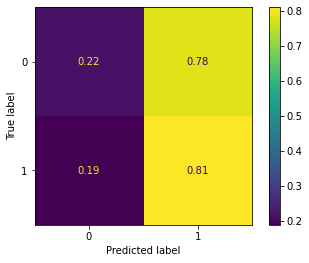

In [22]:
plot_confusion_matrix(loaded_xgb, x_val, y_val, normalize='true')
plt.show()

##### Output transformation
Подготовка данных для рексисовского аутпута:

In [24]:
pivot_table = pd.read_pickle('data/meta/pivot_table_mp_als_svd.pkl')
pivot_table.head(3)

,user_id,val_products,test_products,most_popular,most_popular_val_ap,als,als_val_ap,svd,svd_val_ap
0,1,"[196, 46149, 39657, 38928, 25133, 10258, 35951...","[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.000000,"[13176, 196, 49235, 37710, 46149, 6184, 38928,...",0.432143,"[196, 46149, 49235, 43154, 38928, 13176, 31651...",0.866667
1,2,"[24852, 16589, 1559, 19156, 18523, 22825, 2741...","[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.700000,"[33754, 24852, 18523, 4957, 47209, 33787, 1317...",0.950000,"[47209, 47766, 24852, 45066, 33754, 46676, 495...",0.691667
2,3,"[39190, 47766, 21903, 43961, 17668]","[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.291667,"[21903, 47766, 21137, 16797, 42265, 43961, 432...",0.833333,"[47766, 21903, 9387, 22035, 16797, 43961, 5212...",0.833333


In [26]:
df_val_short = df_val_ss[['user_id', 'product_id']]
df_val_short['xgb_proba'] = y_val_pred_proba
df_val_short = df_val_short.sort_values(by=['user_id', 'xgb_proba'], ascending=False)
df_val_short.reset_index(drop=True, inplace=True)
df_val_short.head(3)

<ipython-input-26-33ac8de60aa7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_short['xgb_proba'] = y_val_pred_proba


,user_id,product_id,xgb_proba
0,206209,26503,0.992201
1,206209,36056,0.973748
2,206209,16066,0.907764


In [27]:
df_val_short_pivot = df_val_short.pivot_table(index='user_id', values=['product_id'], 
                                            aggfunc={'product_id': lambda x: list(x)[:10]}).reset_index()
df_val_short_pivot = df_val_short_pivot.rename({'product_id':'xgb'}, axis=1)
df_val_short_pivot.head()

,user_id,xgb
0,1,"[17122, 46149, 13176, 12427, 10326, 14084, 251..."
1,2,"[17758, 33276, 35917, 18523, 41787, 22474, 165..."
2,3,"[21903, 16797, 14992, 24810, 8021, 21137, 1859..."
3,4,"[37646, 2707, 42329, 43704, 19057, 36606, 1776..."
4,5,"[43693, 48775, 21413, 22475, 28289, 21616, 851..."


In [28]:
pivot_table = pivot_table.merge(df_val_short_pivot, on='user_id', how='left')
pivot_table.head()

,user_id,val_products,test_products,most_popular,most_popular_val_ap,als,als_val_ap,svd,svd_val_ap,xgb
0,1,"[196, 46149, 39657, 38928, 25133, 10258, 35951...","[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.000000,"[13176, 196, 49235, 37710, 46149, 6184, 38928,...",0.432143,"[196, 46149, 49235, 43154, 38928, 13176, 31651...",0.866667,"[17122, 46149, 13176, 12427, 10326, 14084, 251..."
1,2,"[24852, 16589, 1559, 19156, 18523, 22825, 2741...","[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.700000,"[33754, 24852, 18523, 4957, 47209, 33787, 1317...",0.950000,"[47209, 47766, 24852, 45066, 33754, 46676, 495...",0.691667,"[17758, 33276, 35917, 18523, 41787, 22474, 165..."
2,3,"[39190, 47766, 21903, 43961, 17668]","[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.291667,"[21903, 47766, 21137, 16797, 42265, 43961, 432...",0.833333,"[47766, 21903, 9387, 22035, 16797, 43961, 5212...",0.833333,"[21903, 16797, 14992, 24810, 8021, 21137, 1859..."
3,4,"[22199, 25146]","[26576, 25623, 21573]","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.000000,"[37646, 19057, 28204, 8174, 22825, 49235, 4696...",0.000000,"[37646, 19057, 8174, 46969, 16759, 4605, 24184...",0.000000,"[37646, 2707, 42329, 43704, 19057, 36606, 1776..."
4,5,"[27344, 24535, 43693, 40706, 16168, 21413, 139...","[15349, 19057, 16185, 21413, 20843, 20114, 482...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.000000,"[26604, 40706, 8518, 27966, 21616, 11777, 3171...",0.916667,"[26604, 21616, 40706, 31717, 8518, 11777, 5450...",0.733333,"[43693, 48775, 21413, 22475, 28289, 21616, 851..."


In [29]:
pivot_table['xgb_val_ap'] = [AP(pivot_table['val_products'][i], pivot_table['xgb'][i], 10) 
                                       for i in range(len(pivot_table))]
pivot_table.head(3)

,user_id,val_products,test_products,most_popular,most_popular_val_ap,als,als_val_ap,svd,svd_val_ap,xgb,xgb_val_ap
0,1,"[196, 46149, 39657, 38928, 25133, 10258, 35951...","[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.000000,"[13176, 196, 49235, 37710, 46149, 6184, 38928,...",0.432143,"[196, 46149, 49235, 43154, 38928, 13176, 31651...",0.866667,"[17122, 46149, 13176, 12427, 10326, 14084, 251...",0.485714
1,2,"[24852, 16589, 1559, 19156, 18523, 22825, 2741...","[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.700000,"[33754, 24852, 18523, 4957, 47209, 33787, 1317...",0.950000,"[47209, 47766, 24852, 45066, 33754, 46676, 495...",0.691667,"[17758, 33276, 35917, 18523, 41787, 22474, 165...",0.303571
2,3,"[39190, 47766, 21903, 43961, 17668]","[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.291667,"[21903, 47766, 21137, 16797, 42265, 43961, 432...",0.833333,"[47766, 21903, 9387, 22035, 16797, 43961, 5212...",0.833333,"[21903, 16797, 14992, 24810, 8021, 21137, 1859...",0.625000


In [30]:
print_metrics(pivot_table['val_products'].values, pivot_table['xgb'].values, 10)

      metric     value
0  HitRate@k  0.680383
1      MAP@k  0.274459
2     NDCG@k  0.193910


In [31]:
pivot_table.to_pickle('data/meta/pivot_table_mp_als_svd_xgb.pkl')

## Meta classifier

In [23]:
pivot_table = pd.read_pickle('data/meta/pivot_table_mp_als_svd_xgb.pkl')
pivot_table.head(3)

,user_id,val_products,test_products,most_popular,most_popular_val_ap,als,als_val_ap,svd,svd_val_ap,xgb,xgb_val_ap
0,1,"[196, 46149, 39657, 38928, 25133, 10258, 35951...","[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.000000,"[13176, 196, 49235, 37710, 46149, 6184, 38928,...",0.432143,"[196, 46149, 49235, 43154, 38928, 13176, 31651...",0.866667,"[17122, 46149, 13176, 12427, 10326, 14084, 251...",0.485714
1,2,"[24852, 16589, 1559, 19156, 18523, 22825, 2741...","[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.700000,"[33754, 24852, 18523, 4957, 47209, 33787, 1317...",0.950000,"[47209, 47766, 24852, 45066, 33754, 46676, 495...",0.691667,"[17758, 33276, 35917, 18523, 41787, 22474, 165...",0.303571
2,3,"[39190, 47766, 21903, 43961, 17668]","[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.291667,"[21903, 47766, 21137, 16797, 42265, 43961, 432...",0.833333,"[47766, 21903, 9387, 22035, 16797, 43961, 5212...",0.833333,"[21903, 16797, 14992, 24810, 8021, 21137, 1859...",0.625000


In [24]:
pivot_table['best_val_ap'] = pivot_table[['most_popular_val_ap', 'als_val_ap', 'svd_val_ap', 'xgb_val_ap']].idxmax(axis="columns")
pivot_table.head(3)

,user_id,val_products,test_products,most_popular,most_popular_val_ap,als,als_val_ap,svd,svd_val_ap,xgb,xgb_val_ap,best_val_ap
0,1,"[196, 46149, 39657, 38928, 25133, 10258, 35951...","[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.000000,"[13176, 196, 49235, 37710, 46149, 6184, 38928,...",0.432143,"[196, 46149, 49235, 43154, 38928, 13176, 31651...",0.866667,"[17122, 46149, 13176, 12427, 10326, 14084, 251...",0.485714,svd_val_ap
1,2,"[24852, 16589, 1559, 19156, 18523, 22825, 2741...","[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.700000,"[33754, 24852, 18523, 4957, 47209, 33787, 1317...",0.950000,"[47209, 47766, 24852, 45066, 33754, 46676, 495...",0.691667,"[17758, 33276, 35917, 18523, 41787, 22474, 165...",0.303571,als_val_ap
2,3,"[39190, 47766, 21903, 43961, 17668]","[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476...",0.291667,"[21903, 47766, 21137, 16797, 42265, 43961, 432...",0.833333,"[47766, 21903, 9387, 22035, 16797, 43961, 5212...",0.833333,"[21903, 16797, 14992, 24810, 8021, 21137, 1859...",0.625000,als_val_ap


In [25]:
pivot_table['best_val_ap'].value_counts()

svd_val_ap             59781
most_popular_val_ap    55165
als_val_ap             47134
xgb_val_ap             44129
Name: best_val_ap, dtype: int64

In [26]:
pivot_table[['user_id', 'best_val_ap', 'test_products']].head(3)

,user_id,best_val_ap,test_products
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]"


In [27]:
pivot_table[['user_id', 'best_val_ap', 'test_products']].to_pickle('data/meta/pivot_table_best.pkl')

### Most popular recommender

*Надо запустить выше ячейку с классом MostPopularRecommender*

In [28]:
pivot_table = pd.read_pickle('data/meta/pivot_table_best.pkl')
pivot_table.head(3)

,user_id,best_val_ap,test_products
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]"


In [19]:
df_test = pd.read_pickle('data/meta/df_test.pkl')
df_test.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,reordered
0,1,196,10,59,0.169492,1
1,1,10258,9,59,0.152542,1
2,1,10326,1,59,0.016949,0


In [29]:
mpr = MostPopularRecommender()
mpr.fit(df_test)

In [35]:
pivot_table_mp = mpr.predict(pivot_table[pivot_table['best_val_ap'] == 'most_popular_val_ap'])
pivot_table_mp = pivot_table_mp.rename({'most_popular':'predict_products'}, axis=1)
pivot_table_mp.head()

,user_id,best_val_ap,test_products,predict_products
3,4,most_popular_val_ap,"[26576, 25623, 21573]","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
13,14,most_popular_val_ap,"[11042, 32115, 28601, 29615, 15869, 37434, 380...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
17,18,most_popular_val_ap,"[36216, 47546, 21137, 5450, 8518, 22031, 22888...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
27,28,most_popular_val_ap,"[36070, 35510, 43371, 27307, 47626, 41950, 248...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
31,32,most_popular_val_ap,"[4793, 9637, 49215, 14332, 10831, 13049, 6069,...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."


In [36]:
pivot_table_mp.to_pickle('data/meta/pivot_table_predict_mp.pkl')

### ALS

In [38]:
df_test = pd.read_pickle('data/meta/df_test.pkl')

In [39]:
df_test_new = df_test.copy()
df_test_new.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,reordered
0,1,196,10,59,0.169492,1
1,1,10258,9,59,0.152542,1
2,1,10326,1,59,0.016949,0


In [40]:
items = np.unique(df_test_new['product_id'].values)
item_to_encodeditem = {x: i for i, x in enumerate(items)}
df_test_new['product_id_new'] = df_test_new['product_id'].map(item_to_encodeditem)
encodeditem_to_item = {i: x for i, x in enumerate(items)}   

users = np.unique(df_test_new['user_id'].values)
user_to_encodeduser = {x: i for i, x in enumerate(users)}
df_test_new['user_id_new'] = df_test_new['user_id'].map(user_to_encodeduser)
encodeduser_to_user = {i: x for i, x in enumerate(users)}

In [41]:
sparse_item_user = csr_matrix((df_test_new['rating'].astype(float), 
                               (df_test_new['product_id_new'], df_test_new['user_id_new'])))
sparse_user_item = csr_matrix((df_test_new['rating'].astype(float), 
                               (df_test_new['user_id_new'], df_test_new['product_id_new'])))

In [42]:
model_als = implicit.als.AlternatingLeastSquares(regularization=0.3, iterations=20)
model_als.fit(sparse_item_user)

In [43]:
ids = pivot_table[pivot_table['best_val_ap'] == 'als_val_ap']['user_id'].values
ids

array([     2,      3,      5, ..., 206192, 206203, 206205], dtype=int64)

In [55]:
recommendations_ids_enc = []
for i in ids:
    rec = model_als.recommend(i, sparse_user_item, filter_already_liked_items=False)
    rec_ids = [j[0] for j in rec]
    recommendations_ids_enc.append(rec_ids)

In [58]:
recommendations_ids = [[encodeditem_to_item.get(j) for j in i] for i in recommendations_ids_enc]

In [60]:
pivot_table_als = pivot_table[pivot_table['best_val_ap'] == 'als_val_ap']
pivot_table_als['predict_products'] = recommendations_ids
pivot_table_als.head(3)

<ipython-input-60-29be45b5ca4e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_table_als['predict_products'] = recommendations_ids


,user_id,best_val_ap,test_products,predict_products
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[21903, 47766, 16797, 42265, 49683, 43961, 211..."
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]","[37646, 19057, 28204, 25146, 30391, 10749, 492..."
4,5,als_val_ap,"[15349, 19057, 16185, 21413, 20843, 20114, 482...","[21903, 45007, 48679, 38293, 27521, 25890, 196..."


In [61]:
pivot_table_als.to_pickle('data/meta/pivot_table_predict_als.pkl')

### SVD recommender

*Надо запустить выше ячейку с классом SVDRecommender*

In [16]:
pivot_table = pd.read_pickle('data/meta/pivot_table_best.pkl')
pivot_table.head(3)

,user_id,best_val_ap,test_products
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]"


In [17]:
df_test = pd.read_pickle('data/meta/df_test.pkl')
df_test.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,reordered
0,1,196,10,59,0.169492,1
1,1,10258,9,59,0.152542,1
2,1,10326,1,59,0.016949,0


In [18]:
svd = SVDRecommender()
svd.fit(df_test)

In [69]:
pivot_table_svd = svd.predict(pivot_table[pivot_table['best_val_ap'] == 'svd_val_ap'])
pivot_table_svd = pivot_table_svd.rename({'svd': 'predict_products'}, axis=1)
pivot_table_svd.head(3)

,user_id,best_val_ap,test_products,predict_products
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032...","[196, 46149, 43154, 49235, 38928, 13176, 35951..."
7,8,svd_val_ap,"[15937, 5539, 10960, 23165, 22247, 4853, 27104...","[17794, 28985, 9839, 21903, 24838, 34358, 3373..."
9,10,svd_val_ap,"[29650, 48720, 24654, 10177]","[46979, 30489, 16797, 40706, 22035, 27104, 241..."


In [70]:
pivot_table_svd.to_pickle('data/meta/pivot_table_predict_svd.pkl')

### XGBoost

Выделим X и Y:

Train:

In [71]:
df_val_ss = pd.read_pickle('data/meta/df_val_starspace.pkl')
df_val_ss.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,0,1_product,2_product,3_product,4_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,9,50,0.18,196.0,-0.002918,0.001673,-0.008010,-0.001002,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1
1,1,10258,8,50,0.16,10258.0,0.007623,-0.000338,-0.002633,-0.011347,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1
2,1,10326,1,50,0.02,10326.0,0.004164,-0.003791,-0.003216,-0.002906,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,0


In [72]:
x_train = df_val_ss.drop(columns=['user_id', 'product_id', 'rating', 'rating_sum', 'rating_norm', 0, 'reordered']).values
x_train

array([[-0.00291835,  0.00167324, -0.00800956, ...,  0.01106662,
         0.00227354,  0.00174544],
       [ 0.00762294, -0.00033782, -0.00263325, ...,  0.01106662,
         0.00227354,  0.00174544],
       [ 0.00416393, -0.00379092, -0.00321638, ...,  0.01106662,
         0.00227354,  0.00174544],
       ...,
       [ 0.0161963 , -0.0017435 , -0.00811893, ...,  0.0399771 ,
        -0.00459259,  0.0130851 ],
       [-0.0155353 , -0.00745389, -0.0243281 , ...,  0.0333737 ,
        -0.0508194 , -0.00564133],
       [-0.0363765 ,  0.0133833 ,  0.0808543 , ..., -0.0498101 ,
         0.0388307 , -0.00353709]])

In [73]:
y_train = df_val_ss['reordered'].values
y_train

array([1, 1, 0, ..., 0, 1, 1])

In [6]:
x_train.shape, y_train.shape

((11188584, 128), (11188584,))

Test:

In [101]:
df_test_ss = pd.read_pickle('data/meta/df_test_starspace.pkl')
df_test_ss.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,0,1_product,2_product,3_product,4_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,10,59,0.169492,196.0,0.001409,0.005207,0.002497,0.001743,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1
1,1,10258,9,59,0.152542,10258.0,0.005821,0.007413,0.000061,-0.001078,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1
2,1,10326,1,59,0.016949,10326.0,0.002304,0.003594,0.000376,0.000300,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,0


In [102]:
user_ids = pivot_table[pivot_table['best_val_ap'] == 'xgb_val_ap']['user_id'].values
user_ids = list(user_ids)
user_ids[:3]

[6, 9, 23]

In [103]:
df_test_ss_short = df_test_ss[df_test_ss['user_id'].isin(user_ids)]
df_test_ss_short.head()

,user_id,product_id,rating,rating_sum,rating_norm,0,1_product,2_product,3_product,4_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
250,31,196,2,294,0.006803,196.0,0.001409,0.005207,0.002497,0.001743,...,-0.008473,-0.006336,0.00779,-0.002151,-0.000347,-0.006188,0.009488,0.009289,-0.011074,0
251,31,37646,1,294,0.003401,37646.0,0.004316,-0.005409,0.001262,-0.008795,...,-0.008473,-0.006336,0.00779,-0.002151,-0.000347,-0.006188,0.009488,0.009289,-0.011074,0
252,31,42356,1,294,0.003401,42356.0,0.010177,-0.004715,0.007195,-0.016672,...,-0.008473,-0.006336,0.00779,-0.002151,-0.000347,-0.006188,0.009488,0.009289,-0.011074,0
253,31,24231,1,294,0.003401,24231.0,0.001694,-0.006023,0.002217,0.000451,...,-0.008473,-0.006336,0.00779,-0.002151,-0.000347,-0.006188,0.009488,0.009289,-0.011074,0
254,31,41290,1,294,0.003401,41290.0,0.019794,-0.014507,0.023589,-0.018040,...,-0.008473,-0.006336,0.00779,-0.002151,-0.000347,-0.006188,0.009488,0.009289,-0.011074,0


In [104]:
x_test = df_test_ss_short.drop(columns=['user_id', 'product_id', 'rating', 'rating_sum', 'rating_norm', 0, 'reordered']).values
x_test

array([[ 0.00140922,  0.00520674,  0.0024971 , ...,  0.00948807,
         0.00928932, -0.01107448],
       [ 0.00431606, -0.00540889,  0.00126191, ...,  0.00948807,
         0.00928932, -0.01107448],
       [ 0.0101769 , -0.00471523,  0.00719515, ...,  0.00948807,
         0.00928932, -0.01107448],
       ...,
       [-0.0108187 ,  0.00543   , -0.0103784 , ...,  0.0393542 ,
         0.0527798 ,  0.00964663],
       [-0.00631807,  0.0781872 ,  0.0297249 , ..., -0.0497433 ,
        -0.0123232 , -0.0308784 ],
       [ 0.0366284 , -0.0098765 ,  0.00099371, ..., -0.0215989 ,
        -0.00651478, -0.0419927 ]])

In [105]:
y_test = df_test_ss_short['reordered'].values
y_test

array([0, 0, 0, ..., 1, 1, 1])

In [106]:
x_test.shape, y_test.shape

((1968227, 128), (1968227,))

Сделаем андерсемплинг:

In [74]:
rus = RandomUnderSampler()
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)

In [75]:
x_train_rus.shape, y_train_rus.shape

((2459066, 128), (2459066,))

Train XGBClassifier:

In [77]:
best_xgb = XGBClassifier(objective = 'binary:logistic',
                         alpha = 1.10070833548367,
                         colsample_bytree = 0.6068347703263106,
                         learning_rate = 0.8691767919431599,
                         n_estimators = 500,
                         random_state = 42)

In [78]:
%%time
best_xgb.fit(x_train_rus, y_train_rus)

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1h 14min 7s


XGBClassifier(alpha=1.10070833548367, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6068347703263106, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.8691767919431599, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=1.10070837, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [79]:
pickle.dump(best_xgb, open("data/meta/xgboost_test.pickle.dat", "wb"))

In [107]:
loaded_xgb = pickle.load(open("data/meta/xgboost_test.pickle.dat", "rb"))

In [108]:
y_test_pred = loaded_xgb.predict(x_test)
y_test_pred_proba = loaded_xgb.predict_proba(x_test)[:, 1]

In [109]:
print('accuracy_score:', accuracy_score(y_test, y_test_pred), 
      '\nrecall_score:', recall_score(y_test, y_test_pred), 
      '\nprecision_score:', precision_score(y_test, y_test_pred))

accuracy_score: 0.22273548731929801 
recall_score: 0.8741921935754833 
precision_score: 0.11416649464775441


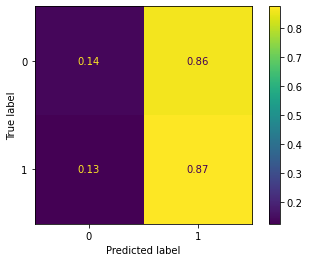

In [110]:
plot_confusion_matrix(loaded_xgb, x_test, y_test, normalize='true')
plt.show()

*Output transformation*

In [111]:
pivot_table = pd.read_pickle('data/meta/pivot_table_best.pkl')
pivot_table.head(3)

,user_id,best_val_ap,test_products
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]"


In [112]:
df_test_ss_short.shape, y_test_pred_proba.shape

((1968227, 135), (1968227,))

In [113]:
df_test_short = df_test_ss_short[['user_id', 'product_id']]
df_test_short['xgb_proba'] = y_test_pred_proba
df_test_short = df_test_short.sort_values(by=['user_id', 'xgb_proba'], ascending=False)
df_test_short.reset_index(drop=True, inplace=True)
df_test_short.head(3)

<ipython-input-113-6c26975b7efd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_short['xgb_proba'] = y_test_pred_proba


,user_id,product_id,xgb_proba
0,206204,9339,0.898983
1,206204,23375,0.784477
2,206204,42828,0.749965


In [114]:
df_test_xgb = df_test_short.pivot_table(index='user_id', values=['product_id'], 
                                            aggfunc={'product_id': lambda x: list(x)[:10]}).reset_index()
df_test_xgb = df_test_xgb.rename({'product_id':'predict_products'}, axis=1)
df_test_xgb.head(3)

,user_id,predict_products
0,6,"[45007, 38293, 40992, 21903, 27521, 10644, 203..."
1,9,"[29594, 39409, 26604, 27555, 10132, 19627, 117..."
2,23,"[25240, 7883, 39063, 5404, 2138, 47141, 23106,..."


In [120]:
pivot_table_xgb = pivot_table[pivot_table['best_val_ap'] == 'xgb_val_ap']
pivot_table_xgb = pivot_table_xgb.merge(df_test_xgb, on='user_id', how='left')
pivot_table_xgb.head()

,user_id,best_val_ap,test_products,predict_products
0,6,xgb_val_ap,"[49401, 25659, 8424]","[45007, 38293, 40992, 21903, 27521, 10644, 203..."
1,9,xgb_val_ap,"[27555, 42347, 27596, 8834, 26604, 12075, 8467...","[29594, 39409, 26604, 27555, 10132, 19627, 117..."
2,23,xgb_val_ap,"[13544, 42372, 33819, 33797, 20468, 13481, 822...","[25240, 7883, 39063, 5404, 2138, 47141, 23106,..."
3,24,xgb_val_ap,[31222],"[48812, 42447, 16393, 46061, 31222, 33081, 234..."
4,25,xgb_val_ap,"[26452, 1216, 37119, 45819, 10096, 22008]","[33741, 22451, 27521, 21506, 22008, 21828, 267..."


In [121]:
pivot_table_xgb.to_pickle('data/meta/pivot_table_predict_xgb.pkl')

### Final prediction

In [135]:
pivot_table_mp = pd.read_pickle('data/meta/pivot_table_predict_mp.pkl')
pivot_table_als = pd.read_pickle('data/meta/pivot_table_predict_als.pkl')
pivot_table_svd = pd.read_pickle('data/meta/pivot_table_predict_svd.pkl')
pivot_table_xgb = pd.read_pickle('data/meta/pivot_table_predict_xgb.pkl')

In [136]:
pivot_table = pd.concat([pivot_table_mp, pivot_table_als, pivot_table_svd, pivot_table_xgb])
pivot_table = pivot_table.sort_values('user_id')
pivot_table.head()

,user_id,best_val_ap,test_products,predict_products
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032...","[196, 46149, 43154, 49235, 38928, 13176, 35951..."
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[21903, 47766, 16797, 42265, 49683, 43961, 211..."
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]","[37646, 19057, 28204, 25146, 30391, 10749, 492..."
3,4,most_popular_val_ap,"[26576, 25623, 21573]","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
4,5,als_val_ap,"[15349, 19057, 16185, 21413, 20843, 20114, 482...","[21903, 45007, 48679, 38293, 27521, 25890, 196..."


In [138]:
pivot_table.shape

(206209, 4)

In [139]:
print_metrics(pivot_table['test_products'].values, pivot_table['predict_products'].values, 10)

      metric     value
0  HitRate@k  0.563768
1      MAP@k  0.319445
2     NDCG@k  0.176719


**Most popular for all data:**

In [142]:
pivot_table_all_mp = mpr.predict(pivot_table)
pivot_table_all_mp.head(3)

,user_id,best_val_ap,test_products,predict_products,most_popular
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032...","[196, 46149, 43154, 49235, 38928, 13176, 35951...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[21903, 47766, 16797, 42265, 49683, 43961, 211...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]","[37646, 19057, 28204, 25146, 30391, 10749, 492...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."


In [143]:
print_metrics(pivot_table_all_mp['test_products'].values, pivot_table_all_mp['most_popular'].values, 10)

      metric     value
0  HitRate@k  0.457027
1      MAP@k  0.220286
2     NDCG@k  0.097616


**ALS for all data:**

In [147]:
recommendations_ids_enc_2 = model_als.recommend_all(sparse_user_item, filter_already_liked_items=False)

In [148]:
recommendations_ids_2 = [[encodeditem_to_item.get(j) for j in i] for i in recommendations_ids_enc_2]

In [149]:
pivot_table_all_als = pivot_table.copy()
pivot_table_all_als['als'] = recommendations_ids_2
pivot_table_all_als.head(3)

,user_id,best_val_ap,test_products,predict_products,als
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032...","[196, 46149, 43154, 49235, 38928, 13176, 35951...","[13176, 196, 49235, 37710, 46149, 38928, 6184,..."
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[21903, 47766, 16797, 42265, 49683, 43961, 211...","[33754, 4957, 33787, 24852, 18523, 47209, 1317..."
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]","[37646, 19057, 28204, 25146, 30391, 10749, 492...","[21903, 47766, 16797, 42265, 49683, 43961, 211..."


In [150]:
print_metrics(pivot_table_all_als['test_products'].values, pivot_table_all_als['als'].values, 10)

      metric     value
0  HitRate@k  0.704683
1      MAP@k  0.356730
2     NDCG@k  0.219106


**SVD Recommender for all data:**

In [19]:
pivot_table_all_svd = svd.predict(pivot_table)
pivot_table_all_svd.head(3)

,user_id,best_val_ap,test_products,svd
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032...","[196, 46149, 43154, 49235, 38928, 13176, 35951..."
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[47209, 24852, 47766, 33754, 45066, 4957, 1852..."
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]","[47766, 21903, 9387, 22035, 43961, 16797, 5212..."


In [20]:
print_metrics(pivot_table_all_svd['test_products'].values, pivot_table_all_svd['svd'].values, 10)

      metric     value
0  HitRate@k  0.657988
1      MAP@k  0.406248
2     NDCG@k  0.226957


**XGBoost for all data:**

In [3]:
df_test_ss = pd.read_pickle('data/meta/df_test_starspace.pkl')
df_test_ss.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,0,1_product,2_product,3_product,4_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,10,59,0.169492,196.0,0.001409,0.005207,0.002497,0.001743,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1
1,1,10258,9,59,0.152542,10258.0,0.005821,0.007413,0.000061,-0.001078,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1
2,1,10326,1,59,0.016949,10326.0,0.002304,0.003594,0.000376,0.000300,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,0


In [4]:
x_test = df_test_ss.drop(columns=['user_id', 'product_id', 'rating', 'rating_sum', 'rating_norm', 0, 'reordered']).values
x_test

array([[ 1.40922000e-03,  5.20674000e-03,  2.49710000e-03, ...,
         2.23773528e-04,  4.25416827e-03, -4.84244922e-03],
       [ 5.82084000e-03,  7.41259000e-03,  6.10580000e-05, ...,
         2.23773528e-04,  4.25416827e-03, -4.84244922e-03],
       [ 2.30375000e-03,  3.59410000e-03,  3.75733000e-04, ...,
         2.23773528e-04,  4.25416827e-03, -4.84244922e-03],
       ...,
       [-1.08187000e-02,  5.43000000e-03, -1.03784000e-02, ...,
         3.93542000e-02,  5.27798000e-02,  9.64663000e-03],
       [-6.31807000e-03,  7.81872000e-02,  2.97249000e-02, ...,
        -4.97433000e-02, -1.23232000e-02, -3.08784000e-02],
       [ 3.66284000e-02, -9.87650000e-03,  9.93708000e-04, ...,
        -2.15989000e-02, -6.51478000e-03, -4.19927000e-02]])

In [5]:
y_test = df_test_ss['reordered'].values
y_test

array([1, 1, 0, ..., 1, 1, 1])

In [6]:
loaded_xgb = pickle.load(open("data/meta/xgboost_test.pickle.dat", "rb"))

In [7]:
y_test_pred_proba = loaded_xgb.predict_proba(x_test)[:, 1]

In [10]:
pivot_table_all_xgb = pd.read_pickle('data/meta/pivot_table_best.pkl')
pivot_table_all_xgb.head(3)

,user_id,best_val_ap,test_products
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]"


In [11]:
df_test_ss_short = df_test_ss[['user_id', 'product_id']]
df_test_ss_short['xgb_proba'] = y_test_pred_proba
df_test_ss_short = df_test_ss_short.sort_values(by=['user_id', 'xgb_proba'], ascending=False)
df_test_ss_short.reset_index(drop=True, inplace=True)
df_test_ss_short.head(3)

<ipython-input-11-5087e2268aa7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_ss_short['xgb_proba'] = y_test_pred_proba


,user_id,product_id,xgb_proba
0,206209,48370,0.997744
1,206209,13176,0.996504
2,206209,23800,0.995650


In [12]:
df_test_xgb = df_test_ss_short.pivot_table(index='user_id', values=['product_id'], 
                                            aggfunc={'product_id': lambda x: list(x)[:10]}).reset_index()
df_test_xgb = df_test_xgb.rename({'product_id':'xgb'}, axis=1)
df_test_xgb.head(3)

,user_id,xgb
0,1,"[26088, 39657, 46149, 12427, 38928, 196, 17122..."
1,2,"[33957, 27413, 19240, 39928, 34688, 21376, 327..."
2,3,"[39190, 38596, 43961, 39922, 1819, 40604, 4776..."


In [13]:
pivot_table_all_xgb = pivot_table_all_xgb.merge(df_test_xgb, on='user_id', how='left')
pivot_table_all_xgb.head()

,user_id,best_val_ap,test_products,xgb
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032...","[26088, 39657, 46149, 12427, 38928, 196, 17122..."
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[33957, 27413, 19240, 39928, 34688, 21376, 327..."
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]","[39190, 38596, 43961, 39922, 1819, 40604, 4776..."
3,4,most_popular_val_ap,"[26576, 25623, 21573]","[36606, 35469, 11865, 37646, 19057, 25146, 423..."
4,5,als_val_ap,"[15349, 19057, 16185, 21413, 20843, 20114, 482...","[22475, 40706, 6808, 11777, 3376, 21616, 18761..."


In [14]:
print_metrics(pivot_table_all_xgb['test_products'].values, pivot_table_all_xgb['xgb'].values, 10)

      metric     value
0  HitRate@k  0.654942
1      MAP@k  0.253678
2     NDCG@k  0.176772


In [21]:
pivot_table_all_xgb.to_pickle('data/meta/pivot_table_all_xgb.pkl')

### Classifier on users embeddings

In [2]:
pivot_table = pd.read_pickle('data/meta/pivot_table_best.pkl')
pivot_table.head(3)

,user_id,best_val_ap,test_products
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]"


**Val**

In [3]:
users_embeddings_val = pd.read_pickle('data/meta/df_val_starspace.pkl')
users_embeddings_val.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,0,1_product,2_product,3_product,4_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,9,50,0.18,196.0,-0.002918,0.001673,-0.008010,-0.001002,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1
1,1,10258,8,50,0.16,10258.0,0.007623,-0.000338,-0.002633,-0.011347,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1
2,1,10326,1,50,0.02,10326.0,0.004164,-0.003791,-0.003216,-0.002906,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,0


In [4]:
users_embeddings_val = users_embeddings_val.drop_duplicates(subset=['user_id']).iloc[:, :70]
users_embeddings_val.reset_index(drop=True, inplace=True)
users_embeddings_val = users_embeddings_val.drop(columns=['product_id', 'rating', 'rating_sum', 'rating_norm', 0])
users_embeddings_val.head(3)

,user_id,1_product,2_product,3_product,4_product,5_product,6_product,7_product,8_product,9_product,...,55_product,56_product,57_product,58_product,59_product,60_product,61_product,62_product,63_product,64_product
0,1,-0.002918,0.001673,-0.00801,-0.001002,-0.000706,0.000638,0.001654,0.003558,-0.002566,...,-0.003054,0.000389,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043
1,15,-0.002918,0.001673,-0.00801,-0.001002,-0.000706,0.000638,0.001654,0.003558,-0.002566,...,-0.003054,0.000389,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043
2,19,-0.002918,0.001673,-0.00801,-0.001002,-0.000706,0.000638,0.001654,0.003558,-0.002566,...,-0.003054,0.000389,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043


In [5]:
users_embeddings_val = users_embeddings_val.merge(pivot_table, on='user_id')
users_embeddings_val.head(3)

,user_id,1_product,2_product,3_product,4_product,5_product,6_product,7_product,8_product,9_product,...,57_product,58_product,59_product,60_product,61_product,62_product,63_product,64_product,best_val_ap,test_products
0,1,-0.002918,0.001673,-0.00801,-0.001002,-0.000706,0.000638,0.001654,0.003558,-0.002566,...,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,15,-0.002918,0.001673,-0.00801,-0.001002,-0.000706,0.000638,0.001654,0.003558,-0.002566,...,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043,als_val_ap,"[196, 10441]"
2,19,-0.002918,0.001673,-0.00801,-0.001002,-0.000706,0.000638,0.001654,0.003558,-0.002566,...,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043,als_val_ap,"[42913, 34690, 25170, 47805, 41483, 40974, 288..."


**Test**

In [6]:
users_embeddings_test = pd.read_pickle('data/meta/df_test_starspace.pkl')
users_embeddings_test.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,0,1_product,2_product,3_product,4_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,10,59,0.169492,196.0,0.001409,0.005207,0.002497,0.001743,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1
1,1,10258,9,59,0.152542,10258.0,0.005821,0.007413,0.000061,-0.001078,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1
2,1,10326,1,59,0.016949,10326.0,0.002304,0.003594,0.000376,0.000300,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,0


In [7]:
users_embeddings_test = users_embeddings_test.drop_duplicates(subset=['user_id']).iloc[:, :70]
users_embeddings_test.reset_index(drop=True, inplace=True)
users_embeddings_test = users_embeddings_test.drop(columns=['product_id', 'rating', 'rating_sum', 'rating_norm', 0])
users_embeddings_test.head(3)

,user_id,1_product,2_product,3_product,4_product,5_product,6_product,7_product,8_product,9_product,...,55_product,56_product,57_product,58_product,59_product,60_product,61_product,62_product,63_product,64_product
0,1,0.001409,0.005207,0.002497,0.001743,0.000704,0.007053,0.000961,0.003151,-0.004303,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372
1,15,0.001409,0.005207,0.002497,0.001743,0.000704,0.007053,0.000961,0.003151,-0.004303,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372
2,19,0.001409,0.005207,0.002497,0.001743,0.000704,0.007053,0.000961,0.003151,-0.004303,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372


**Target encoding**

In [8]:
le = LabelEncoder()
le.fit(users_embeddings_val['best_val_ap'].values)
users_embeddings_val['best_val_ap_enc'] = le.transform(users_embeddings_val['best_val_ap'].values)
users_embeddings_val.head(3)

,user_id,1_product,2_product,3_product,4_product,5_product,6_product,7_product,8_product,9_product,...,58_product,59_product,60_product,61_product,62_product,63_product,64_product,best_val_ap,test_products,best_val_ap_enc
0,1,-0.002918,0.001673,-0.00801,-0.001002,-0.000706,0.000638,0.001654,0.003558,-0.002566,...,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032...",2
1,15,-0.002918,0.001673,-0.00801,-0.001002,-0.000706,0.000638,0.001654,0.003558,-0.002566,...,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043,als_val_ap,"[196, 10441]",0
2,19,-0.002918,0.001673,-0.00801,-0.001002,-0.000706,0.000638,0.001654,0.003558,-0.002566,...,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043,als_val_ap,"[42913, 34690, 25170, 47805, 41483, 40974, 288...",0


In [9]:
le.transform(['svd_val_ap', 'als_val_ap', 'most_popular_val_ap', 'xgb_val_ap'])

array([2, 0, 1, 3])

In [10]:
# users_embeddings_test['best_val_ap_enc'] = le.transform(users_embeddings_test['best_val_ap'].values)
# users_embeddings_test.head(3)

**Preparing X and Y**

In [11]:
x_val = users_embeddings_val.drop(columns=['user_id', 'best_val_ap', 'test_products', 'best_val_ap_enc']).values
x_val

array([[-0.00291835,  0.00167324, -0.00800956, ...,  0.00574046,
        -0.00478865,  0.00104337],
       [-0.00291835,  0.00167324, -0.00800956, ...,  0.00574046,
        -0.00478865,  0.00104337],
       [-0.00291835,  0.00167324, -0.00800956, ...,  0.00574046,
        -0.00478865,  0.00104337],
       ...,
       [ 0.0161963 , -0.0017435 , -0.00811893, ...,  0.0399771 ,
        -0.00459259,  0.0130851 ],
       [-0.0155353 , -0.00745389, -0.0243281 , ...,  0.0333737 ,
        -0.0508194 , -0.00564133],
       [-0.0363765 ,  0.0133833 ,  0.0808543 , ..., -0.0498101 ,
         0.0388307 , -0.00353709]])

In [12]:
y_val = users_embeddings_val['best_val_ap_enc'].values
y_val

array([2, 0, 0, ..., 1, 3, 3])

In [15]:
np.unique(y_val, return_counts=True)

(array([0, 1, 2, 3]), array([47134, 55165, 59781, 44129], dtype=int64))

In [13]:
x_test = users_embeddings_test.drop(columns=['user_id']).values
x_test

array([[ 0.00140922,  0.00520674,  0.0024971 , ..., -0.00648999,
        -0.00163754,  0.00137227],
       [ 0.00140922,  0.00520674,  0.0024971 , ..., -0.00648999,
        -0.00163754,  0.00137227],
       [ 0.00140922,  0.00520674,  0.0024971 , ..., -0.00648999,
        -0.00163754,  0.00137227],
       ...,
       [-0.0108187 ,  0.00543   , -0.0103784 , ...,  0.0393542 ,
         0.0527798 ,  0.00964663],
       [-0.00631807,  0.0781872 ,  0.0297249 , ..., -0.0497433 ,
        -0.0123232 , -0.0308784 ],
       [ 0.0366284 , -0.0098765 ,  0.00099371, ..., -0.0215989 ,
        -0.00651478, -0.0419927 ]])

In [14]:
# y_test = users_embeddings_test['best_val_ap_enc'].values
# y_test

**Train XGBClassifier**

In [16]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

tuned_parameters = [{
#     'colsample_bytree': np.linspace(0.3, 1.0, 8),
#     'learning_rate': np.linspace(0, 1, 11),
    'alpha': np.linspace(0, 10, 5),
    'n_estimators': [100, 500, 1000]
    }]
# tuned_parameters = [{
# #     'colsample_bytree': np.linspace(0.3, 1.0, 1),
#     'learning_rate': np.linspace(0, 1, 1),
#     'alpha': np.linspace(0, 10, 1),
#     'n_estimators': [500],
#     }]

grid_search = GridSearchCV(XGBClassifier(), 
                           param_grid=tuned_parameters,
                           cv=skf,
                           scoring=accuracy_score,
                           n_jobs=-1,
                           verbose=10)     

In [17]:
%%time
grid_search.fit(x_val, y_val)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2h 35min 10s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missin...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                           

In [18]:
pickle.dump(grid_search, open("data/meta/xgboost_val_classifier.pickle.dat", "wb"))

In [19]:
loaded_xgb = pickle.load(open("data/meta/xgboost_val_classifier.pickle.dat", "rb"))

In [20]:
y_val_pred = loaded_xgb.predict(x_val)
print('accuracy_score:', accuracy_score(y_val, y_val_pred))

accuracy_score: 0.3722727911972804


In [21]:
np.unique(y_val_pred, return_counts=True)

(array([0, 1, 2, 3]), array([ 19795,  45634, 109986,  30794], dtype=int64))

In [22]:
y_test_pred = loaded_xgb.predict(x_test)
np.unique(y_test_pred, return_counts=True)

(array([0, 1, 2, 3]), array([ 10034,  17598,  58212, 120365], dtype=int64))

In [25]:
y_test_pred_le = le.inverse_transform(y_test_pred)
y_test_pred_le

array(['xgb_val_ap', 'xgb_val_ap', 'xgb_val_ap', ..., 'xgb_val_ap',
       'xgb_val_ap', 'most_popular_val_ap'], dtype=object)

In [27]:
pivot_table['best_test_xgb'] = y_test_pred_le
pivot_table.head(3)

,user_id,best_val_ap,test_products,best_test_xgb
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032...",xgb_val_ap
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...",xgb_val_ap
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]",xgb_val_ap


In [28]:
pivot_table.to_pickle('data/meta/pivot_table_best_xgb.pkl')

#### Most popular recommender

*Надо запустить выше ячейку с классом MostPopularRecommender*

In [29]:
pivot_table = pd.read_pickle('data/meta/pivot_table_best_xgb.pkl')
pivot_table.head(3)

,user_id,best_val_ap,test_products,best_test_xgb
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032...",xgb_val_ap
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...",xgb_val_ap
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]",xgb_val_ap


In [32]:
df_test = pd.read_pickle('data/meta/df_test.pkl')
df_test.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,reordered
0,1,196,10,59,0.169492,1
1,1,10258,9,59,0.152542,1
2,1,10326,1,59,0.016949,0


In [35]:
mpr = MostPopularRecommender()
mpr.fit(df_test)

In [36]:
pivot_table_mp = mpr.predict(pivot_table[pivot_table['best_test_xgb'] == 'most_popular_val_ap'])
pivot_table_mp = pivot_table_mp.rename({'most_popular':'predict_products'}, axis=1)
pivot_table_mp.head()

,user_id,best_val_ap,test_products,best_test_xgb,predict_products
10615,10616,most_popular_val_ap,"[14005, 15683]",most_popular_val_ap,"[24852, 13176, 21137, 21903, 47209, 47766, 476..."
10616,10617,xgb_val_ap,"[44795, 22825, 6015, 32580, 42828, 11090, 4091...",most_popular_val_ap,"[24852, 13176, 21137, 21903, 47209, 47766, 476..."
10617,10618,als_val_ap,[21386],most_popular_val_ap,"[24852, 13176, 21137, 21903, 47209, 47766, 476..."
10618,10619,als_val_ap,"[24852, 13263, 39491, 20823, 6195, 18498, 2160...",most_popular_val_ap,"[24852, 13176, 21137, 21903, 47209, 47766, 476..."
10619,10620,xgb_val_ap,"[34222, 34862, 31674, 7116, 16953]",most_popular_val_ap,"[24852, 13176, 21137, 21903, 47209, 47766, 476..."


In [37]:
pivot_table_mp.to_pickle('data/meta/pivot_table_best_xgb_mp.pkl')

#### ALS

In [64]:
pivot_table = pd.read_pickle('data/meta/pivot_table_best_xgb.pkl')
pivot_table.head(3)

,user_id,best_val_ap,test_products,best_test_xgb
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032...",xgb_val_ap
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...",xgb_val_ap
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]",xgb_val_ap


In [38]:
df_test = pd.read_pickle('data/meta/df_test.pkl')

In [40]:
df_test_new = df_test.copy()
df_test_new.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,reordered
0,1,196,10,59,0.169492,1
1,1,10258,9,59,0.152542,1
2,1,10326,1,59,0.016949,0


In [41]:
items = np.unique(df_test_new['product_id'].values)
item_to_encodeditem = {x: i for i, x in enumerate(items)}
df_test_new['product_id_new'] = df_test_new['product_id'].map(item_to_encodeditem)
encodeditem_to_item = {i: x for i, x in enumerate(items)}   

users = np.unique(df_test_new['user_id'].values)
user_to_encodeduser = {x: i for i, x in enumerate(users)}
df_test_new['user_id_new'] = df_test_new['user_id'].map(user_to_encodeduser)
encodeduser_to_user = {i: x for i, x in enumerate(users)}

In [42]:
sparse_item_user = csr_matrix((df_test_new['rating'].astype(float), 
                               (df_test_new['product_id_new'], df_test_new['user_id_new'])))
sparse_user_item = csr_matrix((df_test_new['rating'].astype(float), 
                               (df_test_new['user_id_new'], df_test_new['product_id_new'])))

In [43]:
model_als = implicit.als.AlternatingLeastSquares(regularization=0.3, iterations=20)
model_als.fit(sparse_item_user)

In [44]:
ids = pivot_table[pivot_table['best_test_xgb'] == 'als_val_ap']['user_id'].values
ids

array([103367, 103368, 103369, ..., 206018, 206085, 206136], dtype=int64)

In [45]:
recommendations_ids_enc = []
for i in ids:
    rec = model_als.recommend(i, sparse_user_item, filter_already_liked_items=False)
    rec_ids = [j[0] for j in rec]
    recommendations_ids_enc.append(rec_ids)

In [46]:
recommendations_ids = [[encodeditem_to_item.get(j) for j in i] for i in recommendations_ids_enc]

In [47]:
pivot_table_als = pivot_table[pivot_table['best_test_xgb'] == 'als_val_ap']
pivot_table_als['predict_products'] = recommendations_ids
pivot_table_als.head(3)

<ipython-input-47-bf753c4eb00c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_table_als['predict_products'] = recommendations_ids


,user_id,best_val_ap,test_products,best_test_xgb,predict_products
103366,103367,als_val_ap,"[42557, 30450, 48110, 33846, 8518, 3142, 6101,...",als_val_ap,"[40396, 43961, 41665, 10673, 21333, 28993, 149..."
103367,103368,most_popular_val_ap,"[131, 3782, 33045, 40396, 47357, 38881, 13176,...",als_val_ap,"[24852, 21938, 47144, 432, 10749, 15290, 47626..."
103368,103369,most_popular_val_ap,"[3529, 7585, 38548, 6383, 5782, 24852, 432, 53...",als_val_ap,"[24852, 47766, 28204, 19057, 19348, 28849, 241..."


In [48]:
pivot_table_als.to_pickle('data/meta/pivot_table_best_xgb_als.pkl')

#### SVD recommender

*Надо запустить выше ячейку с классом SVDRecommender*

In [49]:
pivot_table = pd.read_pickle('data/meta/pivot_table_best_xgb.pkl')
pivot_table.head(3)

,user_id,best_val_ap,test_products,best_test_xgb
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032...",xgb_val_ap
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...",xgb_val_ap
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]",xgb_val_ap


In [50]:
df_test = pd.read_pickle('data/meta/df_test.pkl')
df_test.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,reordered
0,1,196,10,59,0.169492,1
1,1,10258,9,59,0.152542,1
2,1,10326,1,59,0.016949,0


In [51]:
svd = SVDRecommender()
svd.fit(df_test)

In [52]:
pivot_table_svd = svd.predict(pivot_table[pivot_table['best_test_xgb'] == 'svd_val_ap'])
pivot_table_svd = pivot_table_svd.rename({'svd': 'predict_products'}, axis=1)
pivot_table_svd.head(3)

,user_id,best_val_ap,test_products,best_test_xgb,predict_products
11339,11340,svd_val_ap,"[481, 21616, 42265, 39928, 44422, 21543, 41030...",svd_val_ap,"[21616, 40706, 5450, 26209, 27845, 21903, 3412..."
11340,11341,xgb_val_ap,"[32478, 48415, 18202, 18594, 6104, 3055, 33000]",svd_val_ap,"[8518, 31717, 6184, 27344, 21938, 26369, 48679..."
11341,11342,als_val_ap,"[3211, 39877, 26047, 9421, 31714, 18027, 20794...",svd_val_ap,"[13176, 21137, 5876, 5785, 12341, 39877, 22935..."


In [53]:
pivot_table_svd.to_pickle('data/meta/pivot_table_best_xgb_svd.pkl')

#### XGBoost

In [54]:
df_test_ss = pd.read_pickle('data/meta/df_test_starspace.pkl')
df_test_ss.head(3)

,user_id,product_id,rating,rating_sum,rating_norm,0,1_product,2_product,3_product,4_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,10,59,0.169492,196.0,0.001409,0.005207,0.002497,0.001743,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1
1,1,10258,9,59,0.152542,10258.0,0.005821,0.007413,0.000061,-0.001078,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1
2,1,10326,1,59,0.016949,10326.0,0.002304,0.003594,0.000376,0.000300,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,0


In [56]:
user_ids = pivot_table[pivot_table['best_test_xgb'] == 'xgb_val_ap']['user_id'].values
user_ids = list(user_ids)
user_ids[:5]

[1, 2, 3, 4, 5]

In [57]:
df_test_ss_short = df_test_ss[df_test_ss['user_id'].isin(user_ids)]
df_test_ss_short.head()

,user_id,product_id,rating,rating_sum,rating_norm,0,1_product,2_product,3_product,4_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,10,59,0.169492,196.0,0.001409,0.005207,0.002497,0.001743,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1
1,1,10258,9,59,0.152542,10258.0,0.005821,0.007413,0.000061,-0.001078,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1
2,1,10326,1,59,0.016949,10326.0,0.002304,0.003594,0.000376,0.000300,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,0
3,1,12427,10,59,0.169492,12427.0,0.005686,0.012542,-0.002346,0.008426,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,0
4,1,13032,3,59,0.050847,13032.0,0.004938,0.007218,0.002687,0.007423,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1


In [58]:
x_test = df_test_ss_short.drop(columns=['user_id', 'product_id', 'rating', 'rating_sum', 'rating_norm', 0, 'reordered']).values
x_test

array([[ 1.40922000e-03,  5.20674000e-03,  2.49710000e-03, ...,
         2.23773528e-04,  4.25416827e-03, -4.84244922e-03],
       [ 5.82084000e-03,  7.41259000e-03,  6.10580000e-05, ...,
         2.23773528e-04,  4.25416827e-03, -4.84244922e-03],
       [ 2.30375000e-03,  3.59410000e-03,  3.75733000e-04, ...,
         2.23773528e-04,  4.25416827e-03, -4.84244922e-03],
       ...,
       [ 1.25340000e-02, -2.39580000e-02, -1.71928000e-02, ...,
        -9.66548000e-03,  3.06494000e-02, -4.32946000e-02],
       [ 1.51114000e-02, -4.47402000e-02, -1.94081000e-04, ...,
         2.92602000e-02,  4.18763000e-02, -2.09867000e-02],
       [-6.31807000e-03,  7.81872000e-02,  2.97249000e-02, ...,
        -4.97433000e-02, -1.23232000e-02, -3.08784000e-02]])

In [59]:
y_test = df_test_ss_short['reordered'].values
y_test

array([1, 1, 0, ..., 1, 0, 1])

In [60]:
loaded_xgb = pickle.load(open("data/meta/xgboost_test.pickle.dat", "rb"))

In [61]:
y_test_pred = loaded_xgb.predict(x_test)
y_test_pred_proba = loaded_xgb.predict_proba(x_test)[:, 1]

In [62]:
print('accuracy_score:', accuracy_score(y_test, y_test_pred), 
      '\nrecall_score:', recall_score(y_test, y_test_pred), 
      '\nprecision_score:', precision_score(y_test, y_test_pred))

accuracy_score: 0.21352827408362499 
recall_score: 0.8784901453564825 
precision_score: 0.10240618554751192


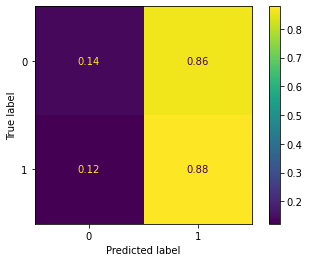

In [63]:
plot_confusion_matrix(loaded_xgb, x_test, y_test, normalize='true')
plt.show()

*Output transformation*

In [65]:
pivot_table = pd.read_pickle('data/meta/pivot_table_best_xgb.pkl')
pivot_table.head(3)

,user_id,best_val_ap,test_products,best_test_xgb
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032...",xgb_val_ap
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...",xgb_val_ap
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]",xgb_val_ap


In [67]:
df_test_short = df_test_ss_short[['user_id', 'product_id']]
df_test_short['xgb_proba'] = y_test_pred_proba
df_test_short = df_test_short.sort_values(by=['user_id', 'xgb_proba'], ascending=False)
df_test_short.reset_index(drop=True, inplace=True)
df_test_short.head(3)

<ipython-input-67-6c26975b7efd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_short['xgb_proba'] = y_test_pred_proba


,user_id,product_id,xgb_proba
0,206208,39578,0.999123
1,206208,41540,0.998195
2,206208,24838,0.998090


In [68]:
df_test_xgb = df_test_short.pivot_table(index='user_id', values=['product_id'], 
                                            aggfunc={'product_id': lambda x: list(x)[:10]}).reset_index()
df_test_xgb = df_test_xgb.rename({'product_id':'predict_products'}, axis=1)
df_test_xgb.head(3)

,user_id,predict_products
0,1,"[26088, 39657, 46149, 12427, 38928, 196, 17122..."
1,2,"[33957, 27413, 19240, 39928, 34688, 21376, 327..."
2,3,"[39190, 38596, 43961, 39922, 1819, 40604, 4776..."


In [69]:
pivot_table_xgb = pivot_table[pivot_table['best_test_xgb'] == 'xgb_val_ap']
pivot_table_xgb = pivot_table_xgb.merge(df_test_xgb, on='user_id', how='left')
pivot_table_xgb.head()

,user_id,best_val_ap,test_products,best_test_xgb,predict_products
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032...",xgb_val_ap,"[26088, 39657, 46149, 12427, 38928, 196, 17122..."
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...",xgb_val_ap,"[33957, 27413, 19240, 39928, 34688, 21376, 327..."
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]",xgb_val_ap,"[39190, 38596, 43961, 39922, 1819, 40604, 4776..."
3,4,most_popular_val_ap,"[26576, 25623, 21573]",xgb_val_ap,"[36606, 35469, 11865, 37646, 19057, 25146, 423..."
4,5,als_val_ap,"[15349, 19057, 16185, 21413, 20843, 20114, 482...",xgb_val_ap,"[22475, 40706, 6808, 11777, 3376, 21616, 18761..."


In [70]:
pivot_table_xgb.to_pickle('data/meta/pivot_table_best_xgb_xgb.pkl')

#### Final prediction

In [71]:
pivot_table_mp = pd.read_pickle('data/meta/pivot_table_best_xgb_mp.pkl')
pivot_table_als = pd.read_pickle('data/meta/pivot_table_best_xgb_als.pkl')
pivot_table_svd = pd.read_pickle('data/meta/pivot_table_best_xgb_svd.pkl')
pivot_table_xgb = pd.read_pickle('data/meta/pivot_table_best_xgb_xgb.pkl')

In [72]:
pivot_table = pd.concat([pivot_table_mp, pivot_table_als, pivot_table_svd, pivot_table_xgb])
pivot_table = pivot_table.sort_values('user_id')
pivot_table.head()

,user_id,best_val_ap,test_products,best_test_xgb,predict_products
0,1,svd_val_ap,"[196, 25133, 38928, 26405, 39657, 10258, 13032...",xgb_val_ap,"[26088, 39657, 46149, 12427, 38928, 196, 17122..."
1,2,als_val_ap,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...",xgb_val_ap,"[33957, 27413, 19240, 39928, 34688, 21376, 327..."
2,3,als_val_ap,"[39190, 18599, 23650, 21903, 47766, 24810]",xgb_val_ap,"[39190, 38596, 43961, 39922, 1819, 40604, 4776..."
3,4,most_popular_val_ap,"[26576, 25623, 21573]",xgb_val_ap,"[36606, 35469, 11865, 37646, 19057, 25146, 423..."
4,5,als_val_ap,"[15349, 19057, 16185, 21413, 20843, 20114, 482...",xgb_val_ap,"[22475, 40706, 6808, 11777, 3376, 21616, 18761..."


In [73]:
pivot_table.shape

(206209, 5)

In [76]:
print_metrics(pivot_table['test_products'].values, pivot_table['predict_products'].values, 10)

      metric     value
0  HitRate@k  0.618984
1      MAP@k  0.287355
2     NDCG@k  0.178045
